# 2 layer synthetic inversion, with a regional field

Here we try to recover the true Layer 2 topography with a gravity inversion. The gravity data is the forward gravity of Layer 1, 2, and 3, representing a perfect gravity survey with no error. The inputs into the inversion are a full resolution Layer 1, representing the `ice surface`, a low resolution Layer 2, representing the `bed topography`, which has been created through the random sampling and grid of 30 contraint points. In an Antarctic setting, these points represent single seismic survey locations which image the elevation of Layer 2. While not included as a layer in the inversion, the forward gravity of Layer3 is included in the observed gravity. This field represents the regional gravity signal from factors such as long wavelength crustal thickness variations. 

import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import regional, synthetic, plotting, optimization, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings

import os

# Set region and parameters

Use the same regions and parameters as `synthetic_model_simple_with_regional.ipynb`

In [2]:
# set grid parameters
spacing = 1e3
registration = "g"
inversion_region = [0, 80e3, 0, 60e3]

# set gravity observation parameters
grav_observation_height = 1000
grav_spacing = 1e3  # true spacing was 2km for sampled, 1km for full res

buffer_region = utils.alter_region(
    inversion_region,
    # buffer=12e3,
)[1]

print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

inversion region =  [0, 80000.0, 0, 60000.0]
buffer region =  [0, 80000, 0, 60000]


# Load data

## topographic layers
* 3 full resolution synthetic layers
* low resolution layer 2

In [3]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1_simple.zarr").z

true_layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2_simple.zarr").z

starting_layer2 = xr.open_zarr(
    "../synthetic_data/synthetic_starting_layer2_simple.zarr"
)["z"]

layer3 = xr.open_zarr("../synthetic_data/synthetic_layer3_simple.zarr").z

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
true_layer2 = true_layer2.astype(np.float64)
starting_layer2 = starting_layer2.astype(np.float64)
layer3 = layer3.astype(np.float64)

# resample all layer to same spacing / extent
layer1 = fetch.resample_grid(
    layer1,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
true_layer2 = fetch.resample_grid(
    true_layer2,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
starting_layer2 = fetch.resample_grid(
    starting_layer2,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
layer3 = fetch.resample_grid(
    layer3,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)

print(utils.get_grid_info(starting_layer2))
starting_layer2

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


returning original grid
returning original grid
returning original grid
returning original grid
(1000.0, [0.0, 80000.0, 0.0, 60000.0], -800.682556152, -493.858032227, 'g')


<xarray.DataArray 'z' (y: 61, x: 81)>
dask.array<astype, shape=(61, 81), dtype=float64, chunksize=(61, 81), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 1e+03 2e+03 3e+03 ... 7.7e+04 7.8e+04 7.9e+04 8e+04
  * y        (y) float64 0.0 1e+03 2e+03 3e+03 ... 5.7e+04 5.8e+04 5.9e+04 6e+04
Attributes:
    actual_range:  [-800.6825561523438, -493.8580322265625]
    long_name:     z

## gravity data
* full resolution gravity grid
* gravity observations

In [4]:
# load resolution gravity grid
synthetic_gravity = xr.open_zarr(
    "../synthetic_data/synthetic_forward_grav_simple_with_regional.zarr"
)

# use full grid
grav = vd.grid_to_table(synthetic_gravity.astype(np.float64))

# set standard column names
grav = grav.rename(columns={"forward_total": "Gobs"})

# remove other columns
grav_survey = grav[["x", "y", "Gobs", "z"]]

# center gravity around 0
grav.Gobs -= grav.Gobs.median()

print(f"gravity: {len(grav)} points")
print(f"gravity avg. elevation: {int(np.nanmean(grav.z))}")

# grid the observed gravity
Gobs = grav.set_index(["y", "x"]).to_xarray().Gobs

grav

gravity: 4941 points
gravity avg. elevation: 1000


y        x    Layer1    Layer2    Layer3       Gobs       z
0         0.0      0.0  7.079618  3.117193  0.348744   8.507185  1000.0
1         0.0   1000.0  8.411450  3.754956  0.323825  10.451861  1000.0
2         0.0   2000.0  8.769055  4.018826  0.295379  11.044890  1000.0
3         0.0   3000.0  8.776992  4.091908  0.263643  11.094172  1000.0
4         0.0   4000.0  8.645779  4.074078  0.229239  10.910725  1000.0
...       ...      ...       ...       ...       ...        ...     ...
4936  60000.0  76000.0  1.019056  1.619829  2.836632   3.437148  1000.0
4937  60000.0  77000.0  1.105780  1.598040  2.715206   3.380656  1000.0
4938  60000.0  78000.0  1.194986  1.552608  2.566119   3.275342  1000.0
4939  60000.0  79000.0  1.282108  1.453309  2.389775   3.086822  1000.0
4940  60000.0  80000.0  1.354322  1.245943  2.192249   2.754144  1000.0

[4941 rows x 7 columns]

## constraint points

In [5]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints_simple.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all,
    inversion_region,
)

print(f"bathymetry control points:{len(constraint_points)}")
constraint_points.head()

bathymetry control points:30


x             y           z
0  33361.760376   5900.810030 -718.817246
1  57625.959475  25266.457500 -750.543650
2      9.149985  57473.371809 -492.362531
3  24186.605811  31989.917098 -688.832116
4  11740.471265  41512.626837 -604.955236

## plot inputs

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


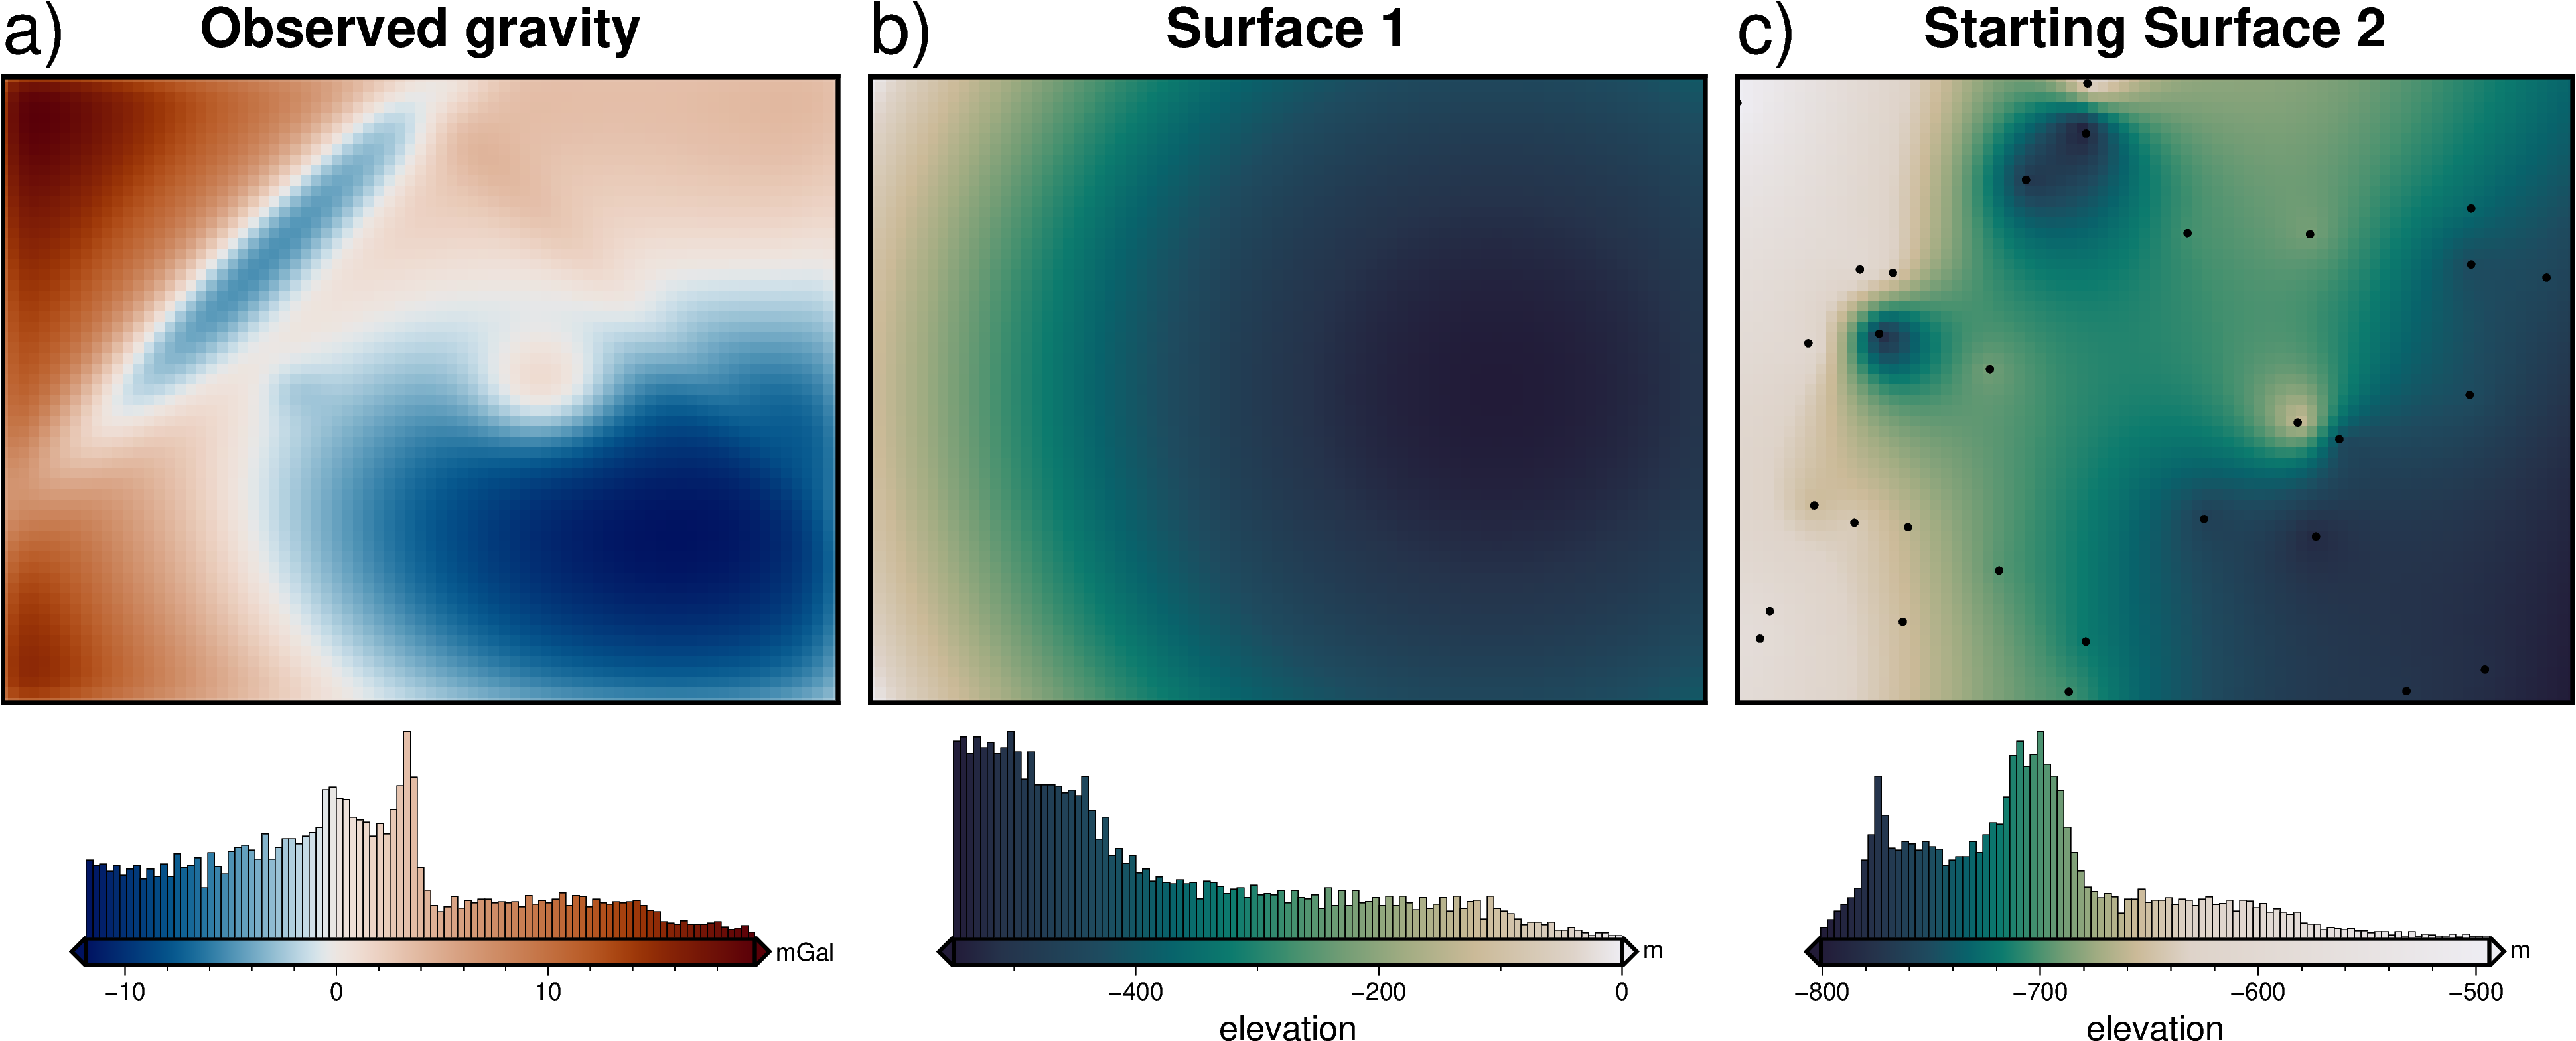

In [7]:
# plot observed gravity
fig = maps.plot_grd(
    grid=Gobs,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Observed gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 1
fig = maps.plot_grd(
    grid=layer1,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Surface 1",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="c)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

# Bouguer correction

The `observed gravity` includes a gravitational signal from density contrast across Layer 1 (air-ice), Layer 2 (ice-bed), and Layer 3 (regional field). Since we want to invert for Layer 2, we need to remove the component of this gravity from Layer 1 and Layer 3. Here we show how to remove the Layer 1 component, and later will show how to remove the Layer 3 component.

To do this, we build a series of vertical prisms around a flat reference, which we take to be the mean value of Layer 1. The prisms extend above or below this reference, towards Layer 1. Prisms above the reference are assigned a positive density contrast ($\rho_{ice}$ - $\rho_{air}$), while prisms below the reference are assigned a negative density contrast ($\rho_{air}$ - $\rho_{ice}$). This is shown in b) and c) of the below figure.

At each stage of the inversion, the we ensure the updated bed elevation doesn't intersect Layer 1. This means the Layer 1 density contrast will be constant throughout the inversion, and can thus be calculated and accounted for only once, at the beginning. 

Here, we calculate the forward gravity of this density contrast, and remove it from the observed gravity to make a `corrected observed gravity`. 

<img src="../figures/synthetic_model_simple_2layer.svg" width="1000"/>

## Ice prisms

In [6]:
# create prisms around Layer 1
# positive densities above reference, negative below
layer1_prisms = inv_utils.grids_to_prisms(
    surface=layer1,
    reference=layer1.values.mean(),
    density=xr.where(layer1 >= layer1.values.mean(), 917, -917),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## ice gravity

In [7]:
# calculate gravity of layer1
layer1_grid, layer1_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    grav,
    names=["layer1_prisms"],
    remove_median=True,
    progressbar=True,
    plot=False,
)

grav["layer1_forward"] = layer1_df.forward_total

# subtract from observed gravity
grav["Gobs_corr"] = grav.Gobs - grav.layer1_forward

# center on 0
grav["Gobs_corr"] -= grav["Gobs_corr"].median()

# grid the results
layer1_forward = grav.set_index(["y", "x"]).to_xarray().layer1_forward
Gobs_corr = grav.set_index(["y", "x"]).to_xarray().Gobs_corr

# center on 0
layer1_forward -= np.median(layer1_forward)
Gobs_corr -= np.median(Gobs_corr)
grav

  0%|                                                  | 0/4941 [00:00<?, ?it/s]

y        x    Layer1    Layer2    Layer3       Gobs       z  \
0         0.0      0.0  7.079618  3.117193  0.348744   8.507185  1000.0   
1         0.0   1000.0  8.411450  3.754956  0.323825  10.451861  1000.0   
2         0.0   2000.0  8.769055  4.018826  0.295379  11.044890  1000.0   
3         0.0   3000.0  8.776992  4.091908  0.263643  11.094172  1000.0   
4         0.0   4000.0  8.645779  4.074078  0.229239  10.910725  1000.0   
...       ...      ...       ...       ...       ...        ...     ...   
4936  60000.0  76000.0  1.019056  1.619829  2.836632   3.437148  1000.0   
4937  60000.0  77000.0  1.105780  1.598040  2.715206   3.380656  1000.0   
4938  60000.0  78000.0  1.194986  1.552608  2.566119   3.275342  1000.0   
4939  60000.0  79000.0  1.282108  1.453309  2.389775   3.086822  1000.0   
4940  60000.0  80000.0  1.354322  1.245943  2.192249   2.754144  1000.0   

      layer1_forward  Gobs_corr  
0           7.079618   2.493278  
1           8.411450   3.106122  
2           8.769055   3.341546  
3           8.776992   3.382891  
4           8.645779   3.330658  
...              ...        ...  
4936        1.019056   3.483802  
4937        1.105780   3.340586  
4938        1.194986   3.146067  
4939        1.282108   2.870425  
4940        1.354322   2.465532  

[4941 rows x 9 columns]

returning original grid
returning original grid


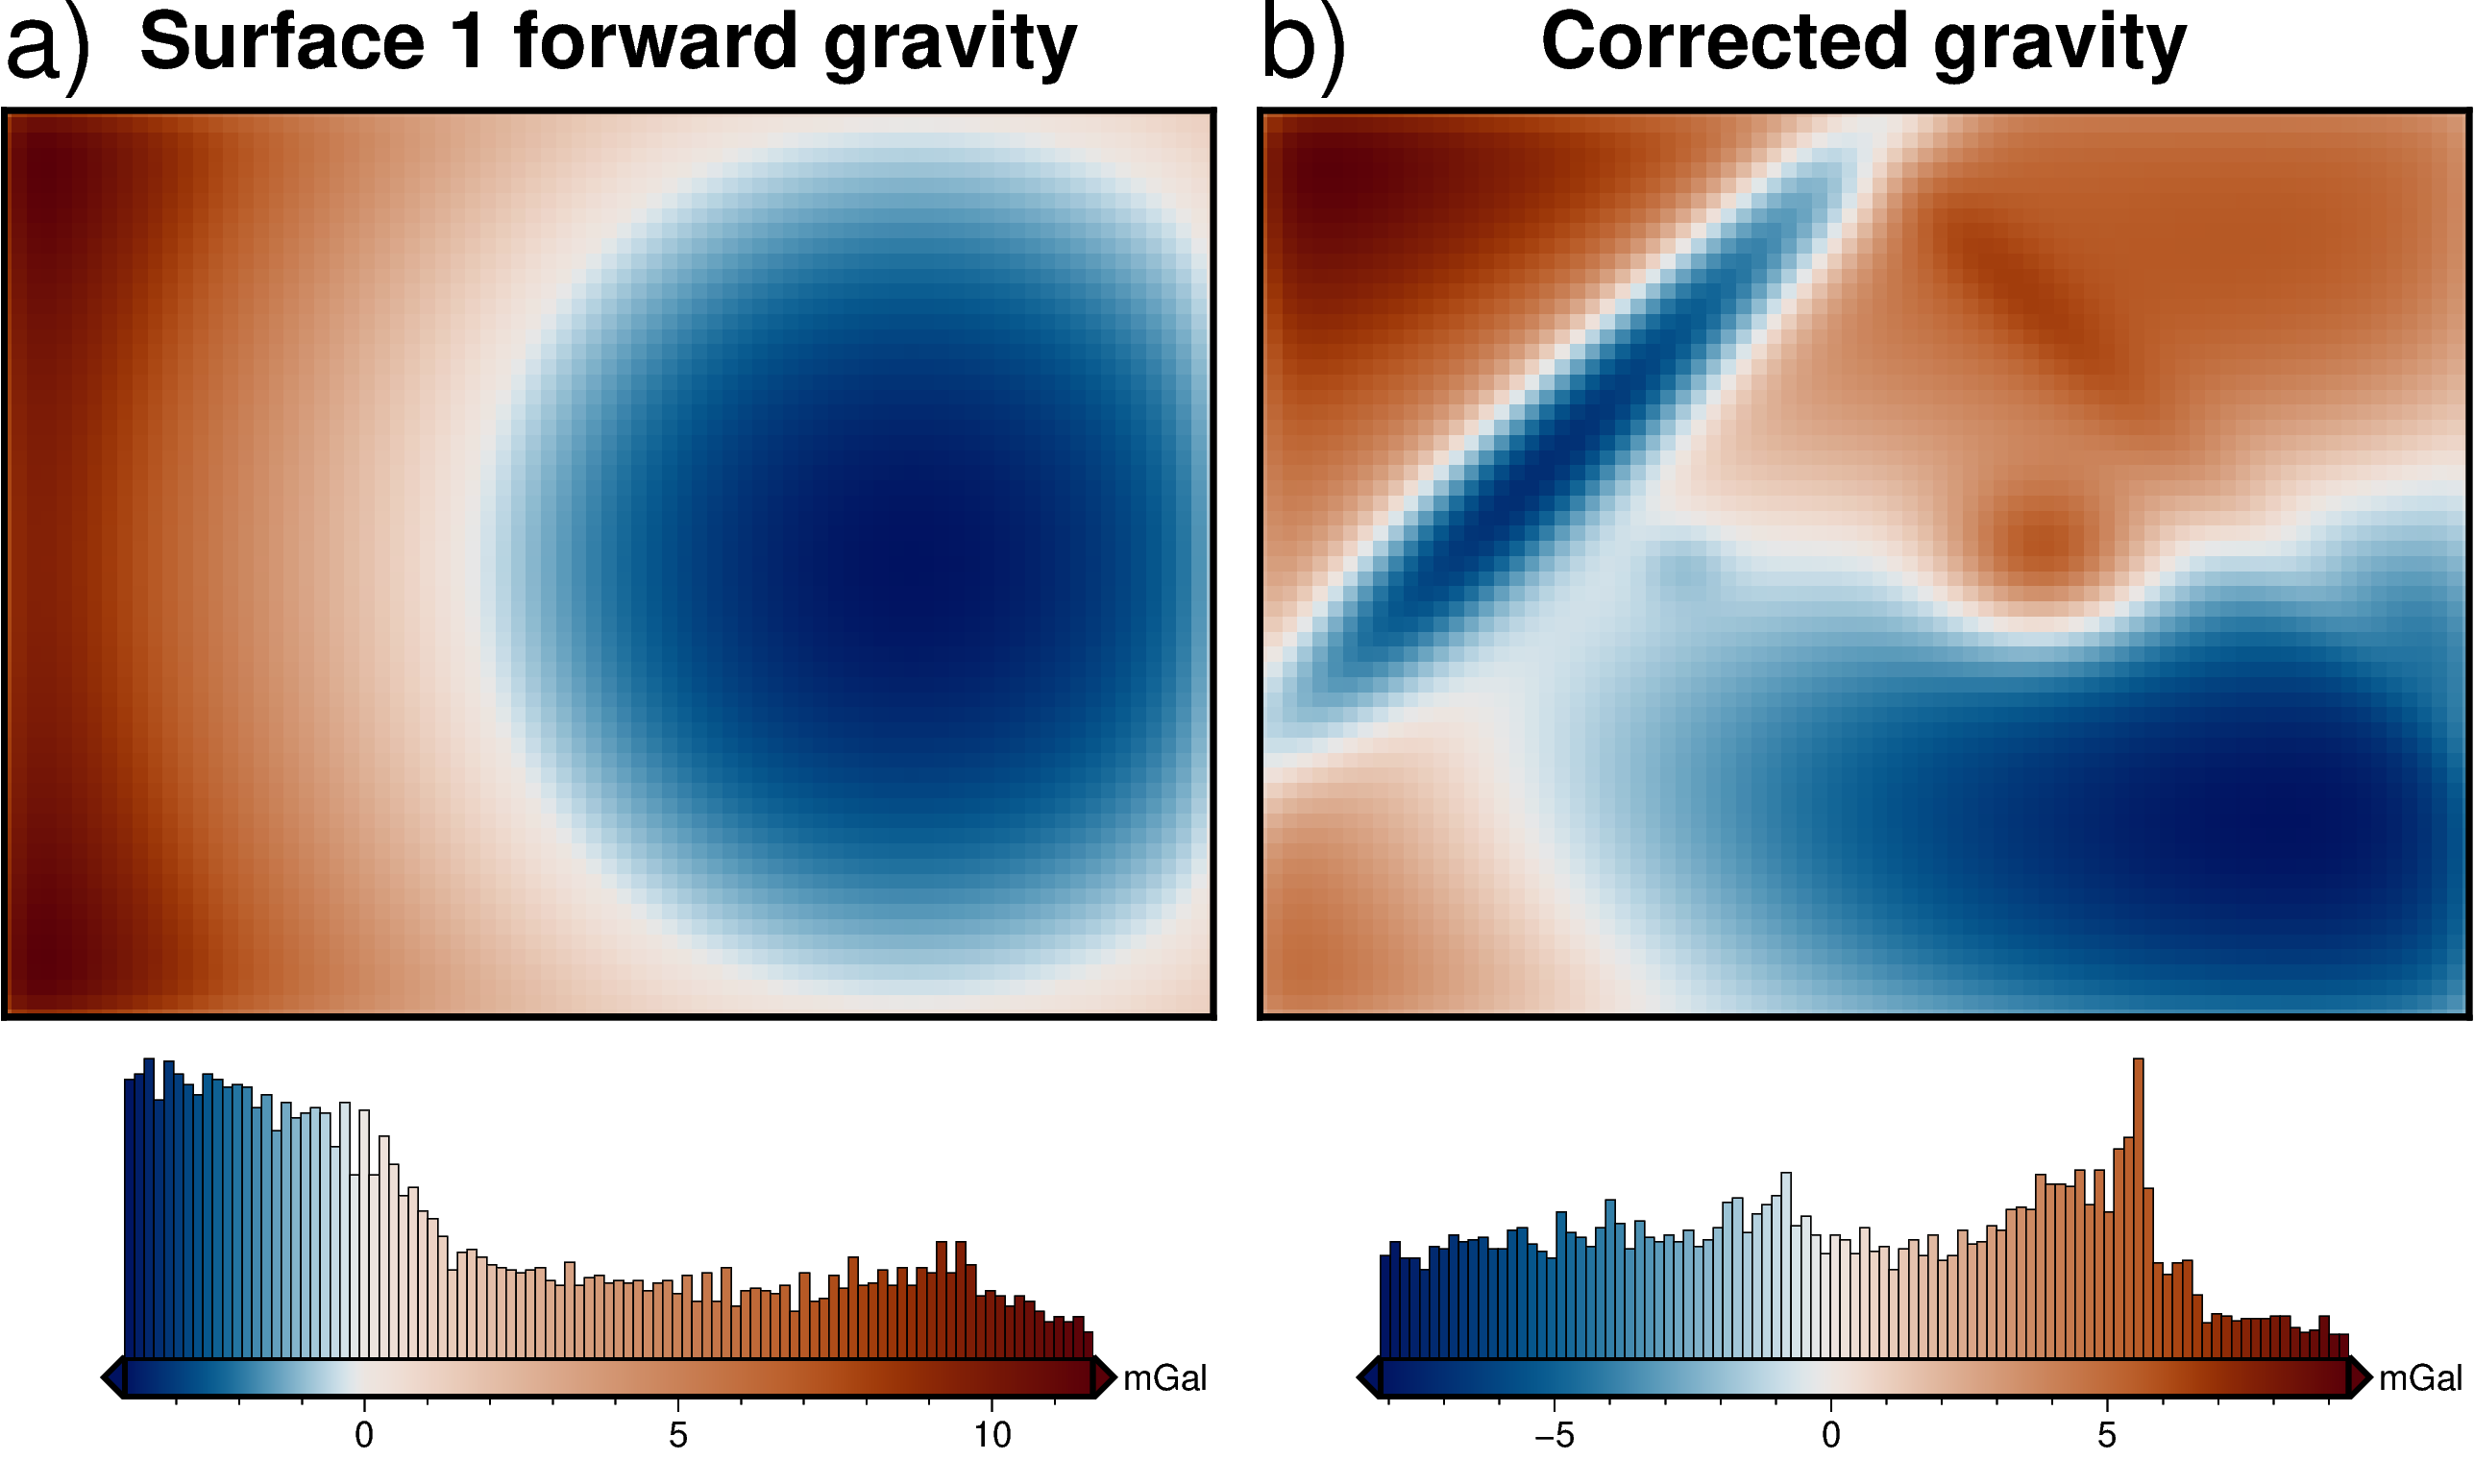

In [10]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=layer1_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Surface 1 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig.show()

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution Layer 2 density contrast. This will be the input into our inversion.


## Bed prisms

In [8]:
# create prisms around Layer 2
# positive densities above reference, negative below
layer2_prisms = inv_utils.grids_to_prisms(
    surface=starting_layer2,
    reference=starting_layer2.values.mean(),
    density=xr.where(
        starting_layer2 >= starting_layer2.values.mean(), 2300 - 917, -(2300 - 917)
    ),
)

# plotting.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## bed gravity

In [9]:
# calculate gravity of layer1
layer2_forward, layer2_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    grav,
    names=["layer2_prisms"],
    remove_median=True,
    progressbar=True,
    plot=False,
)
layer2_forward = layer2_forward.forward_total

grav["layer2_forward"] = layer2_df.forward_total
grav

  0%|                                                  | 0/4941 [00:00<?, ?it/s]

y        x    Layer1    Layer2    Layer3       Gobs       z  \
0         0.0      0.0  7.079618  3.117193  0.348744   8.507185  1000.0   
1         0.0   1000.0  8.411450  3.754956  0.323825  10.451861  1000.0   
2         0.0   2000.0  8.769055  4.018826  0.295379  11.044890  1000.0   
3         0.0   3000.0  8.776992  4.091908  0.263643  11.094172  1000.0   
4         0.0   4000.0  8.645779  4.074078  0.229239  10.910725  1000.0   
...       ...      ...       ...       ...       ...        ...     ...   
4936  60000.0  76000.0  1.019056  1.619829  2.836632   3.437148  1000.0   
4937  60000.0  77000.0  1.105780  1.598040  2.715206   3.380656  1000.0   
4938  60000.0  78000.0  1.194986  1.552608  2.566119   3.275342  1000.0   
4939  60000.0  79000.0  1.282108  1.453309  2.389775   3.086822  1000.0   
4940  60000.0  80000.0  1.354322  1.245943  2.192249   2.754144  1000.0   

      layer1_forward  Gobs_corr  layer2_forward  
0           7.079618   2.493278        2.445618  
1           8.411450   3.106122        2.974444  
2           8.769055   3.341546        3.201610  
3           8.776992   3.382891        3.268290  
4           8.645779   3.330658        3.253918  
...              ...        ...             ...  
4936        1.019056   3.483802       -0.349516  
4937        1.105780   3.340586       -0.382226  
4938        1.194986   3.146067       -0.393327  
4939        1.282108   2.870425       -0.362025  
4940        1.354322   2.465532       -0.253643  

[4941 rows x 10 columns]

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


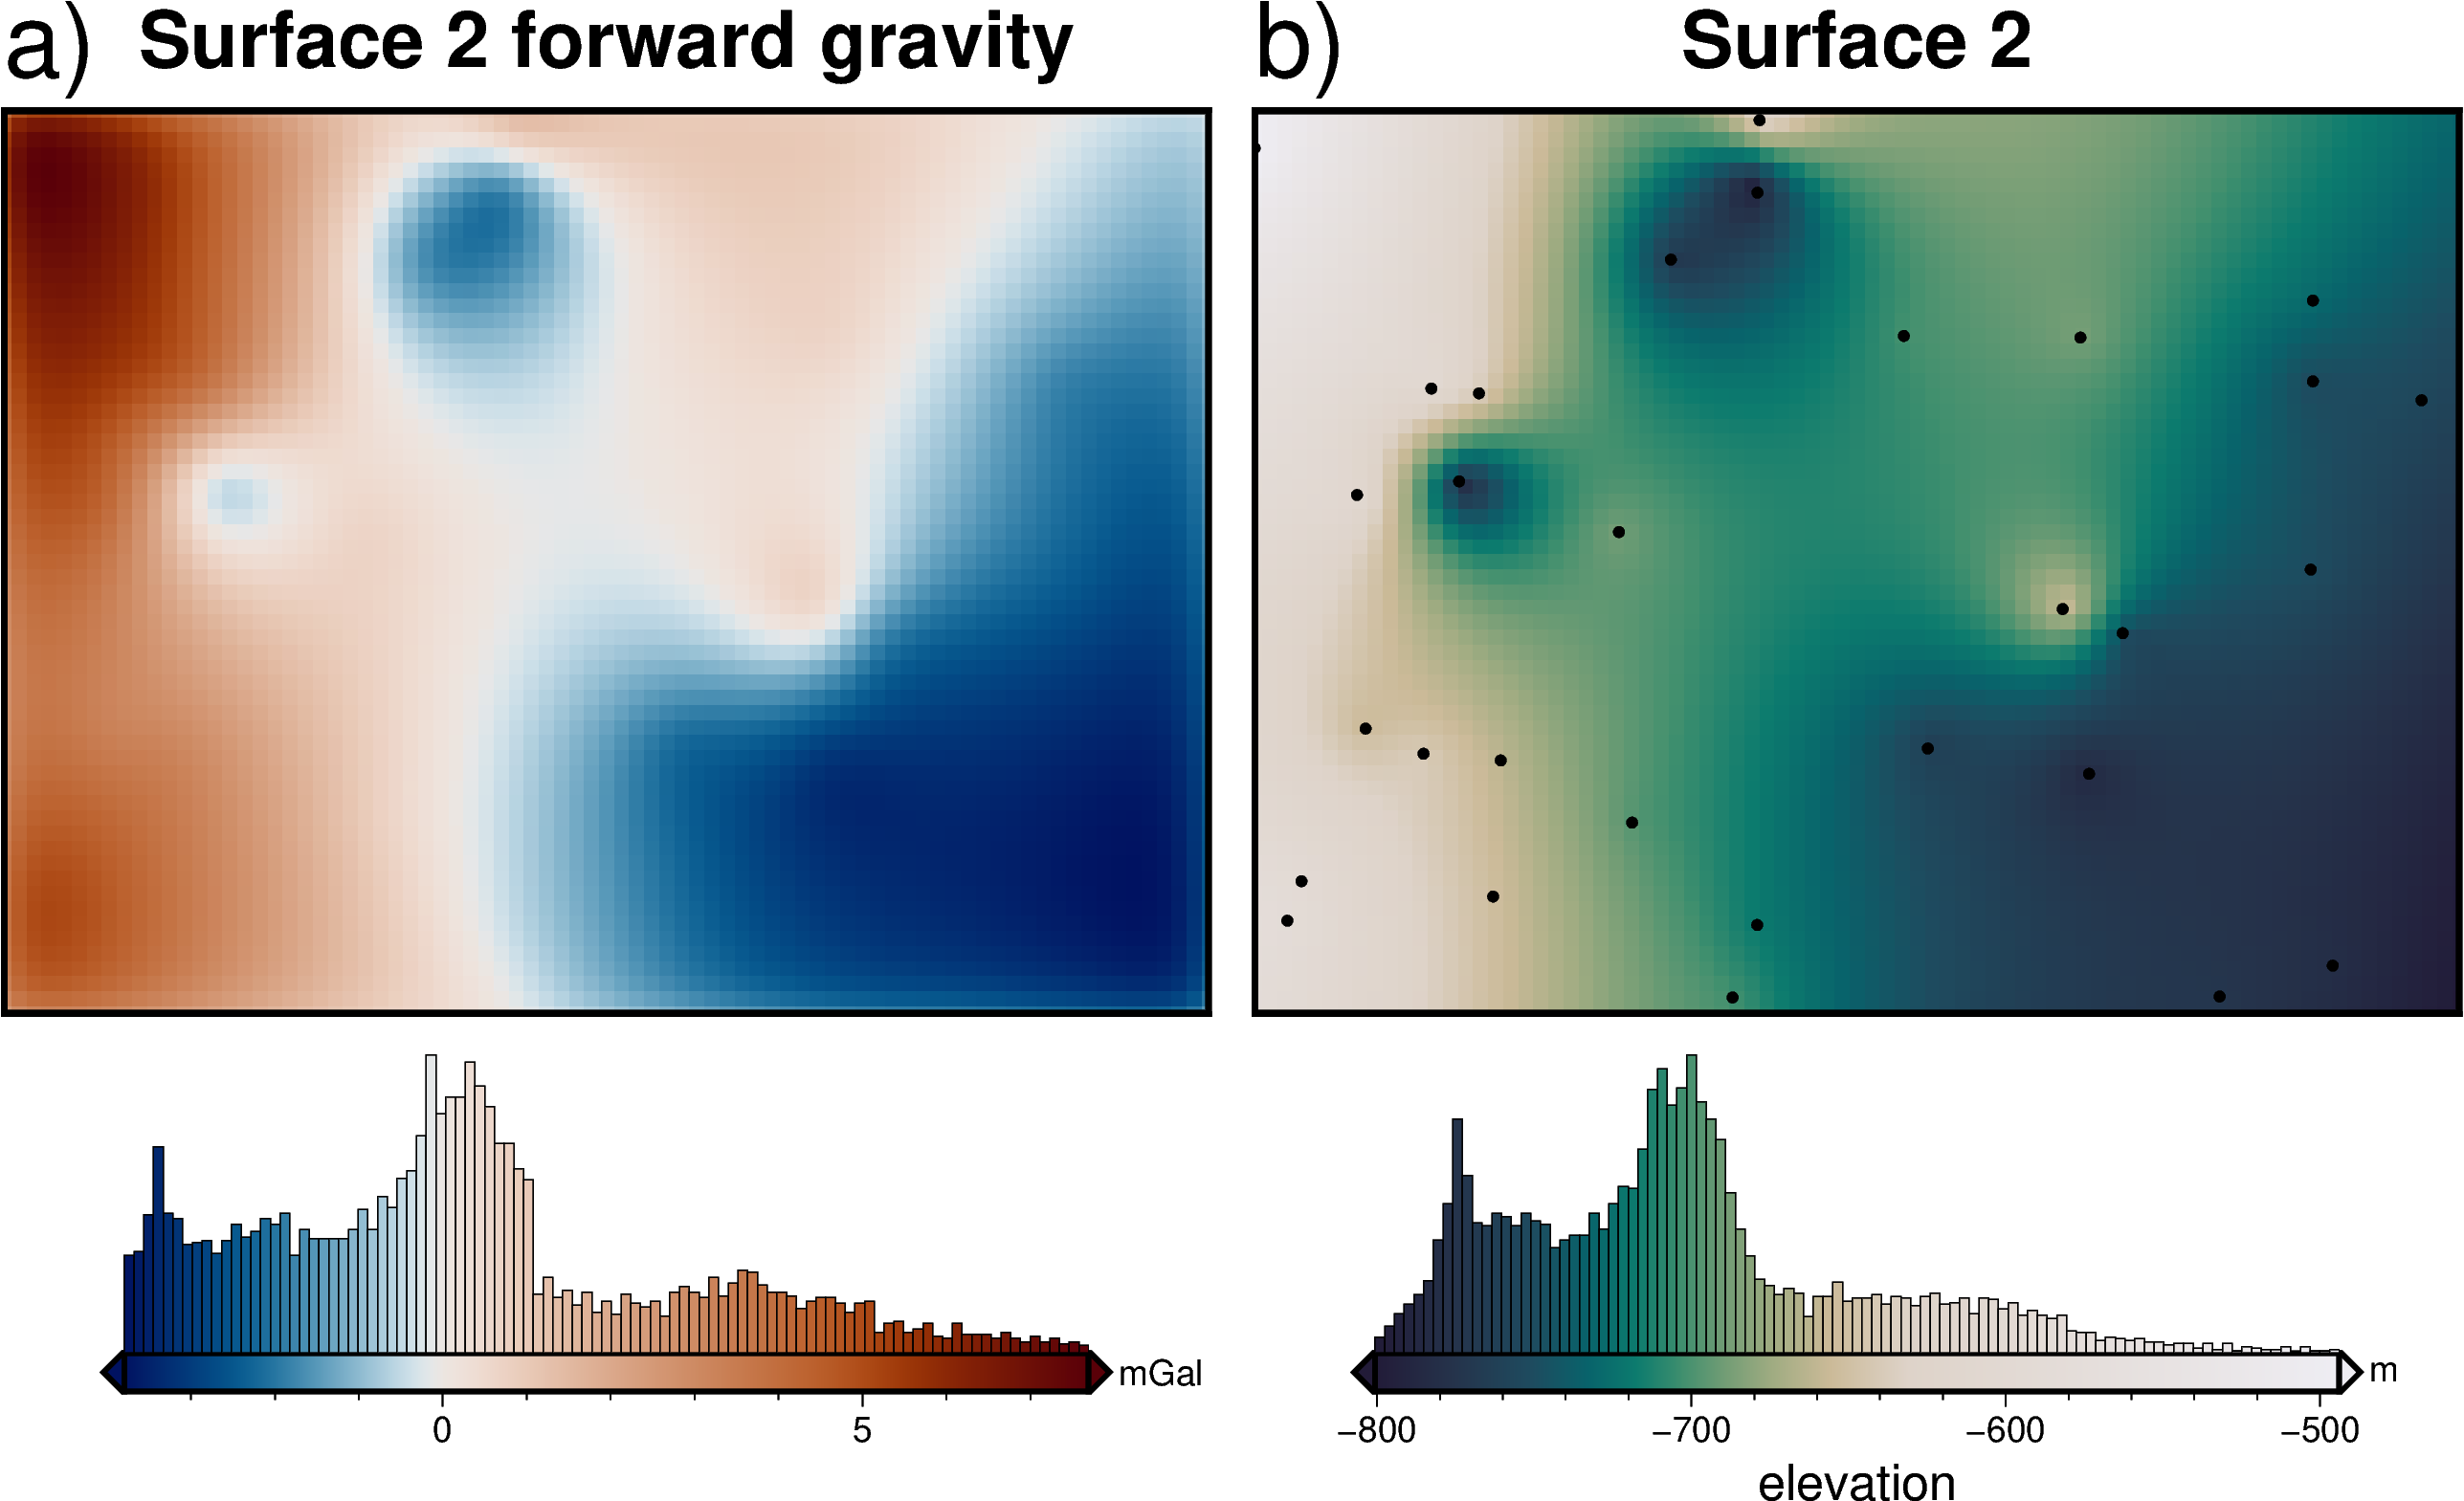

In [13]:
# plot layer 2 gravity
fig = maps.plot_grd(
    grid=layer2_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Surface 2 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
# plot layer 2 topography
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig.show()

## Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `Surface 2` and `Surface 3`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `Surface 2` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of `Surface 2`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `Surface 2` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `Surface 2` and the low-resolution `Surface 2`. 

If we fail to accurately remove the `regional` signal, the resulting `Surface 2` surface after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we create the synthetic model, we precisely know the regional component (the forward gravity of `Surface 3`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

In [10]:
# load the true regional gravity anomaly
true_layer3_grav = fetch.resample_grid(
    synthetic_gravity.Layer3,
    region=inversion_region,
    spacing=grav_spacing,
    registration=registration,
)

returning original grid


### optimize the regional-residual seperation

We have 4 methods to seperate the regional misfit from the residual misfit.
1) `Filter` method: Apply a low-pass filter to the misfit
2) `Trend` method: Fit a trend to the misfit
3) `Constraints` method: Sample and grid the misfit only at constraint points, where we know the true layer depth
4) `Equivalent-Sources` method: Predict the gravity anomaly resulting from a serious of deep sources.

Each of these methods has 1 parameter to tune. Respectively, these are 
1) gaussian low-pass filter width (1km - 1000km)
2) trend order (1 - 20)
3) gridding tension factor (0 - 1)
4) source depth (10km - 10,000km)

The optimization will explore the parameter space of each of these, and return the parameters which result in your choice of:
a) a `regional misfit` closest to the true layer 3 forward gravity,
b) the smallest `residuals` at the constraint points

Since we know the true `regional` field, we will use method a). For a true inversion where you don't know the `regional` field, you can use method b). This method finds the seperation method which minimize the `residuals` at contraint points. Since at these contraint points you know the starting layer elevation is accurate, the misfit should be entirely due to the `regional` field, and the `residual` should be close to 0. 

Choose to either run all 4 methods in the same optimization, or run each seperately. 

In [11]:
regional_kwargs = dict(
    input_grav=grav,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_layer3_grav,
    constraints=constraint_points,
)

#### Optimize 4 methods together

In [ ]:
# # set comparison_method
# comparison_method='minimize_constraints'
# # comparison_method='regional_comparison'

# # set name and storage for the optimization
# study_name = f"regional_seperation_together_{comparison_method}"
# storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# # set number of runs
# n_trials=100

# # create a new study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define objective function
# objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method_options = [
#             "filter",
#             "trend",
#             "constraints",
#             "eq_sources",
#         ],
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         study, study_df = optimization.optuna_parallel(
#             study_name=study_name,
#             study_storage=storage,
#             objective = objective,
#             n_trials=n_trials,
#             maximize_cpus=True,
#         )

# optuna.visualization.plot_optimization_history(study).show()
# optuna.visualization.plot_slice(study).show()

# plotting.plot_best_param(study_df, comparison_method, **regional_kwargs)

#### Optimize methods individually

In [ ]:
# # set comparison method
# comparison_method='minimize_constraints'
# # comparison_method='regional_comparison'

# # set regional method
# # regional_method = "filter"
# regional_method = "trend"
# # regional_method = "constraints"
# # regional_method = "eq_sources"

# # set name and storage for the optimization
# study_name = f"regional_seperation_{regional_method}_{comparison_method}"
# storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# # set number of runs
# n_trials=50

# # create a new study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective = optimization.optimal_regional_params(
#     comparison_method = comparison_method,
#     regional_method = regional_method,
#     filter_limits = [10e3, 1000e3, 10e3], # 100 options
#     trend_limits = [1, 20, 1], # 20 options
#     constraints_limits = [0, 1, 0.01], # 101 options
#     eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#     **regional_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         study, study_df = optimization.optuna_parallel(
#             study_name=study_name,
#             study_storage=storage,
#             objective=objective,
#             n_trials=n_trials,
#             maximize_cpus=True,
#         )

# optuna.visualization.plot_optimization_history(study).show()
# optuna.visualization.plot_slice(study).show()

# plotting.plot_best_param(study_df, comparison_method, regional_method=regional_method, **regional_kwargs)

## Optimize all methods individually

/tmp/ipykernel_3506924/2528633973.py:55: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))



########## filter ##########
number                                       47
value                                  0.861497
datetime_start       2023-02-27 16:43:09.612818
datetime_complete    2023-02-27 16:43:41.144474
duration                 0 days 00:00:31.531656
params_filter                             10000
state                                  COMPLETE
Name: 47, dtype: object
returning original grid
returning original grid


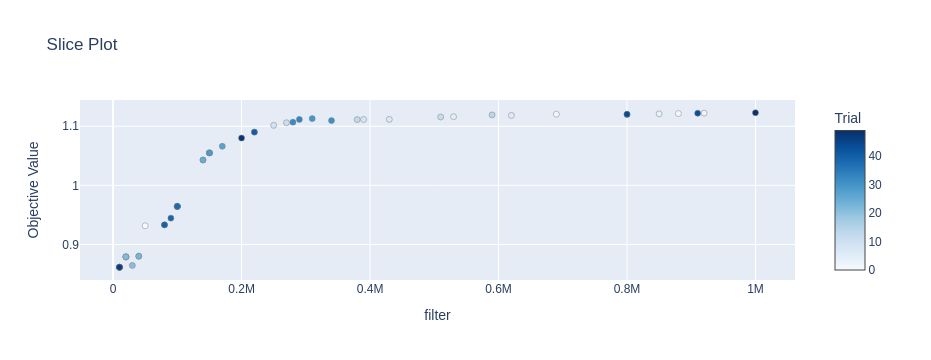

/tmp/ipykernel_3506924/2528633973.py:55: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.




########## trend ##########
number                                       24
value                                  0.805499
datetime_start       2023-02-27 16:43:44.198220
datetime_complete    2023-02-27 16:44:09.317678
duration                 0 days 00:00:25.119458
params_trend                                  4
state                                  COMPLETE
Name: 24, dtype: object
returning original grid
returning original grid


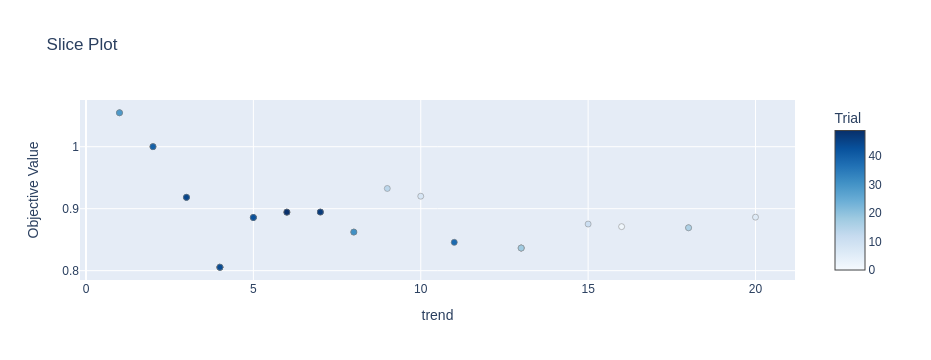


########## constraints ##########
number                                         7
value                                    0.72578
datetime_start        2023-02-27 16:44:35.680454
datetime_complete     2023-02-27 16:44:44.684103
duration                  0 days 00:00:09.003649
params_constraints                          0.09
state                                   COMPLETE
Name: 7, dtype: object


/tmp/ipykernel_3506924/2528633973.py:55: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



returning original grid
returning original grid



########## eq_sources ##########
number                                       33
value                                  0.754706
datetime_start       2023-02-27 16:45:37.503335
datetime_complete    2023-02-27 16:46:34.358092
duration                 0 days 00:00:56.854757
params_eq_sources                       1130000
state                                  COMPLETE
Name: 33, dtype: object


/tmp/ipykernel_3506924/2528633973.py:55: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



returning original grid
returning original grid


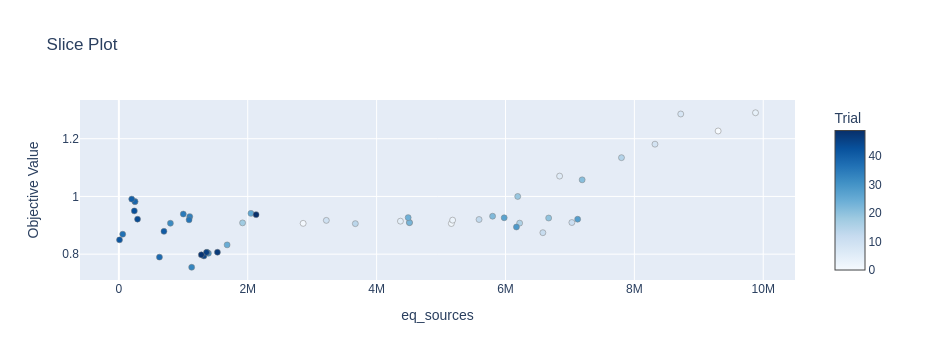

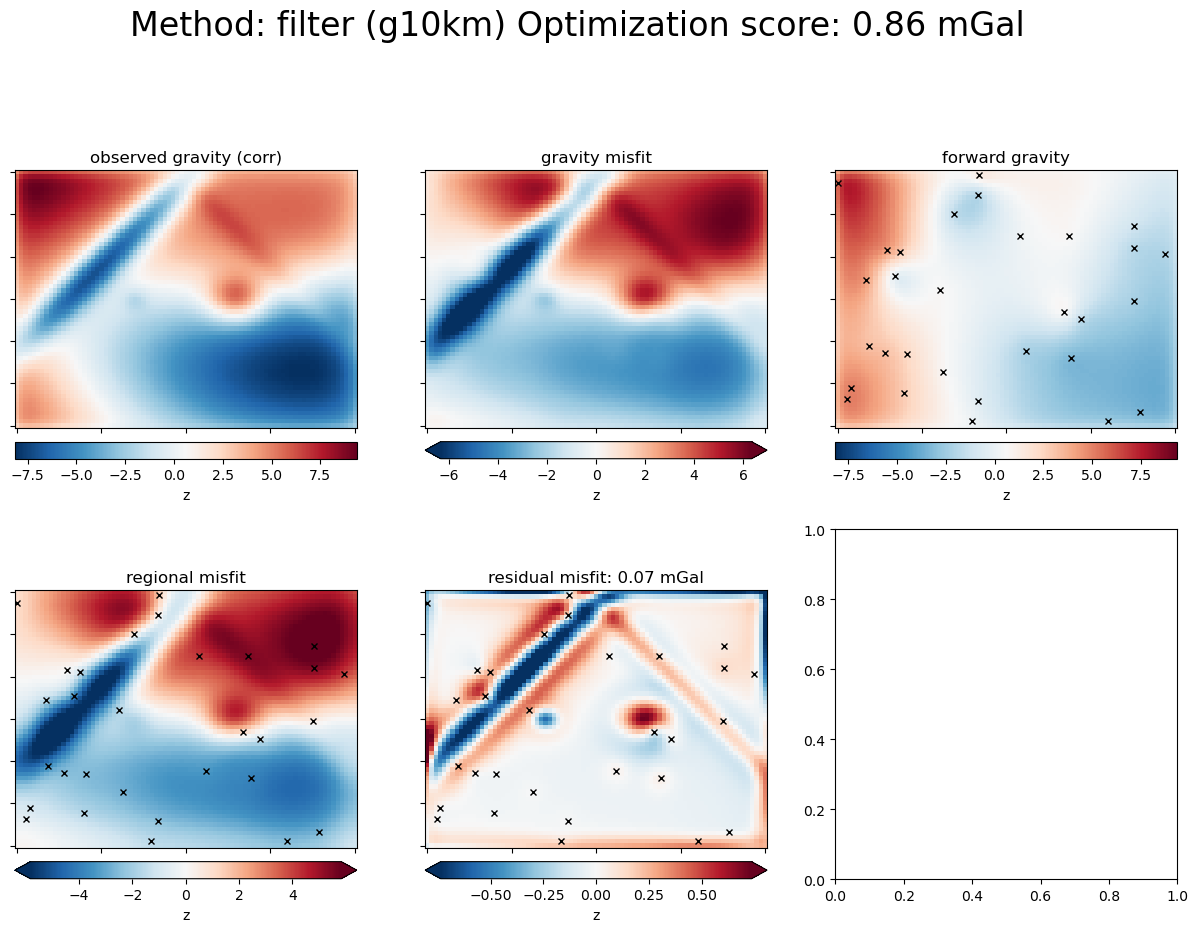

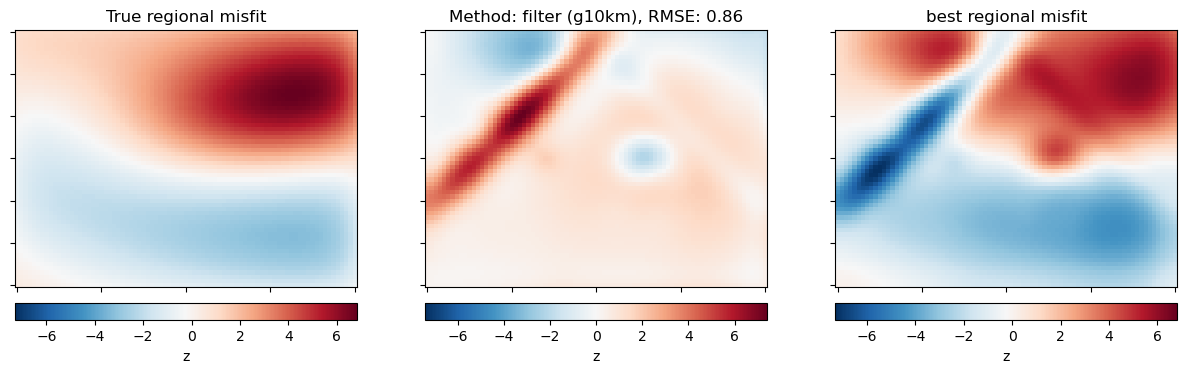

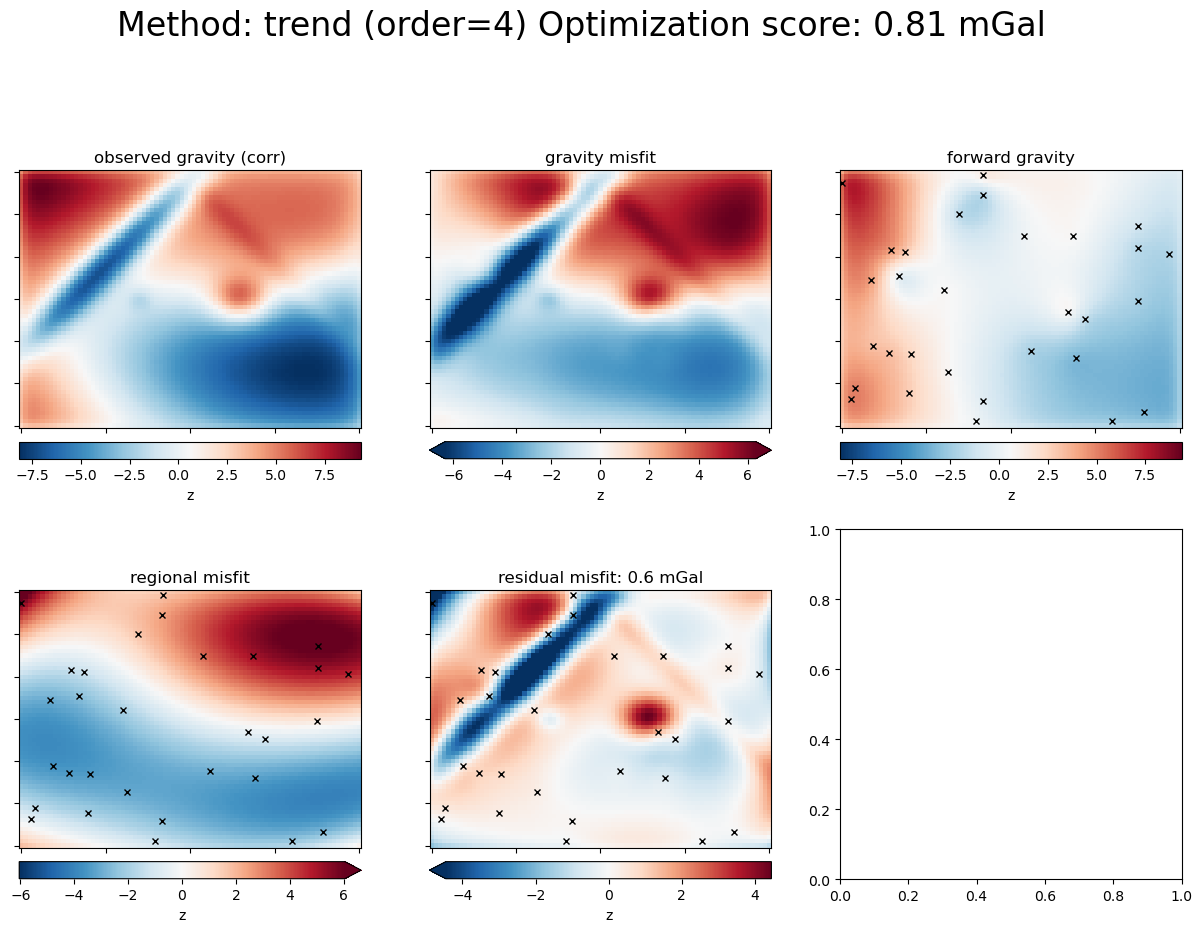

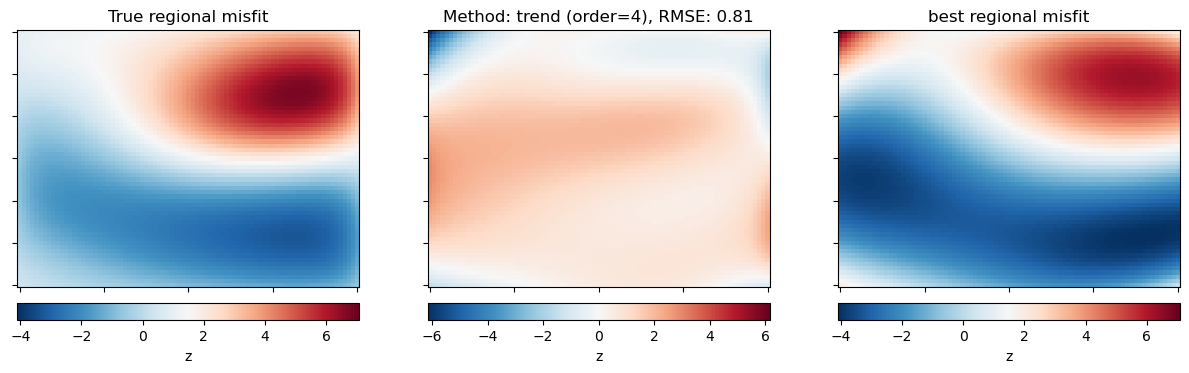

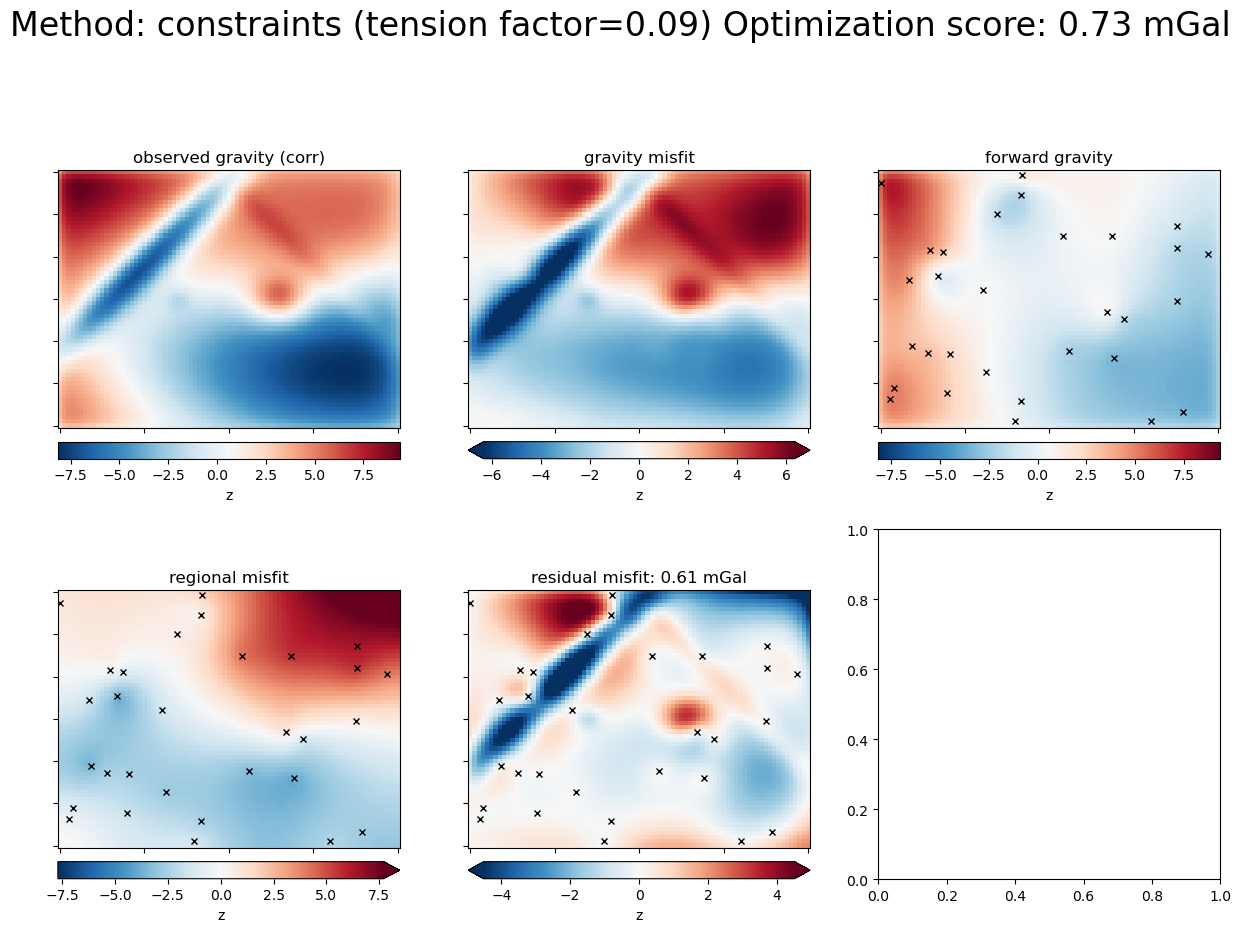

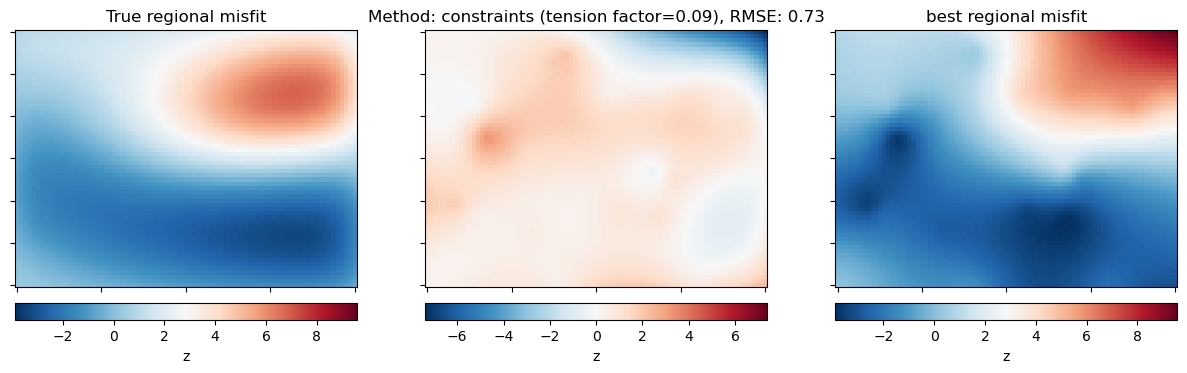

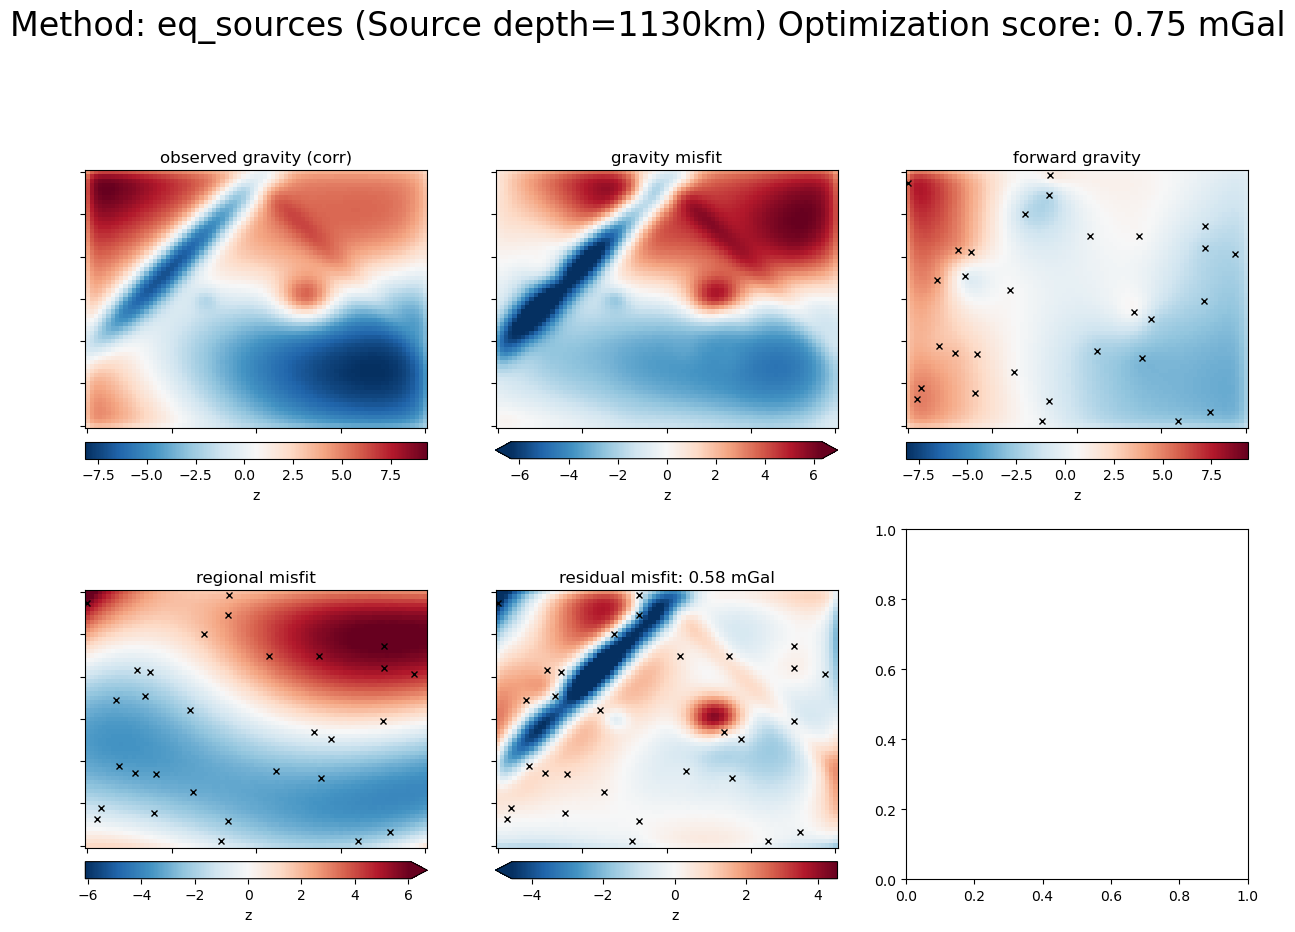

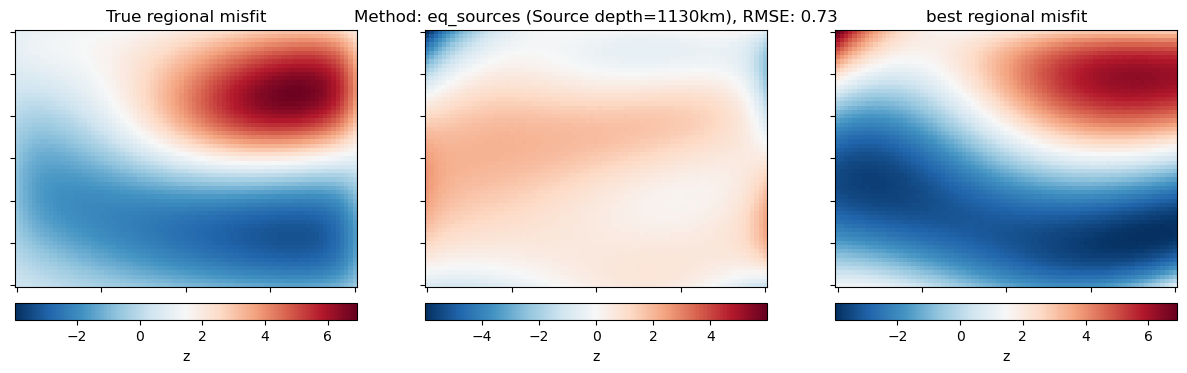

In [12]:
# set comparison method
# comparison_method='minimize_constraints'
comparison_method = "regional_comparison"

methods = ["filter", "trend", "constraints", "eq_sources"]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"regional_seperation_indiv_{i}_{comparison_method}"
#     storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

#     # set number of runs
#     n_trials=50

#     # create a new study
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#         )

#     # define the objective function
#     objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = optimization.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#             )

# load studies
study_dfs = []
for i in methods:
    study_name = f"regional_seperation_indiv_{i}_{comparison_method}"
    storage = JournalStorage(
        JournalFileStorage(f"../optimization_logs/{study_name}.log")
    )
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df)

    # plot results
    plotting.plot_best_param(
        study_df, comparison_method, regional_method=i, **regional_kwargs
    )
    optuna.visualization.plot_slice(study).show()

studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v["params_method"] = k

regional_sep_combined_studies = pd.concat(
    studies.values(), ignore_index=True
).sort_values(by="value")

In [13]:
df = regional_sep_combined_studies
df.head()

number     value             datetime_start          datetime_complete  \
126      26  0.725780 2023-02-27 16:44:35.757116 2023-02-27 16:45:06.979035   
107       7  0.725780 2023-02-27 16:44:35.680454 2023-02-27 16:44:44.684103   
144      44  0.726513 2023-02-27 16:44:35.781936 2023-02-27 16:45:28.402766   
127      27  0.726513 2023-02-27 16:44:35.756804 2023-02-27 16:45:08.436841   
143      43  0.726948 2023-02-27 16:44:35.786697 2023-02-27 16:45:27.314063   

                  duration  params_filter     state params_method  \
126 0 days 00:00:31.221919            NaN  COMPLETE   constraints   
107 0 days 00:00:09.003649            NaN  COMPLETE   constraints   
144 0 days 00:00:52.620830            NaN  COMPLETE   constraints   
127 0 days 00:00:32.680037            NaN  COMPLETE   constraints   
143 0 days 00:00:51.527366            NaN  COMPLETE   constraints   

     params_trend  params_constraints  params_eq_sources  
126           NaN                0.09                NaN  
107           NaN                0.09                NaN  
144           NaN                0.10                NaN  
127           NaN                0.10                NaN  
143           NaN                0.11                NaN

In [14]:
best_filter = df[df.params_method == "filter"].iloc[0].number
best_trend = df[df.params_method == "trend"].iloc[0].number
best_constraints = df[df.params_method == "constraints"].iloc[0].number
best_eq_sources = df[df.params_method == "eq_sources"].iloc[0].number

print(f"best trial w/ solver = verde: index {best_filter}")
print(f"best trial w/ solver = scipy: index {best_trend}")
print(f"best trial w/ deriv = prisms: index {best_constraints}")
print(f"best trial w/ deriv = annulus: index {best_eq_sources}")

best trial w/ solver = verde: index 47
best trial w/ solver = scipy: index 33
best trial w/ deriv = prisms: index 26
best trial w/ deriv = annulus: index 33


## Best regional seperation

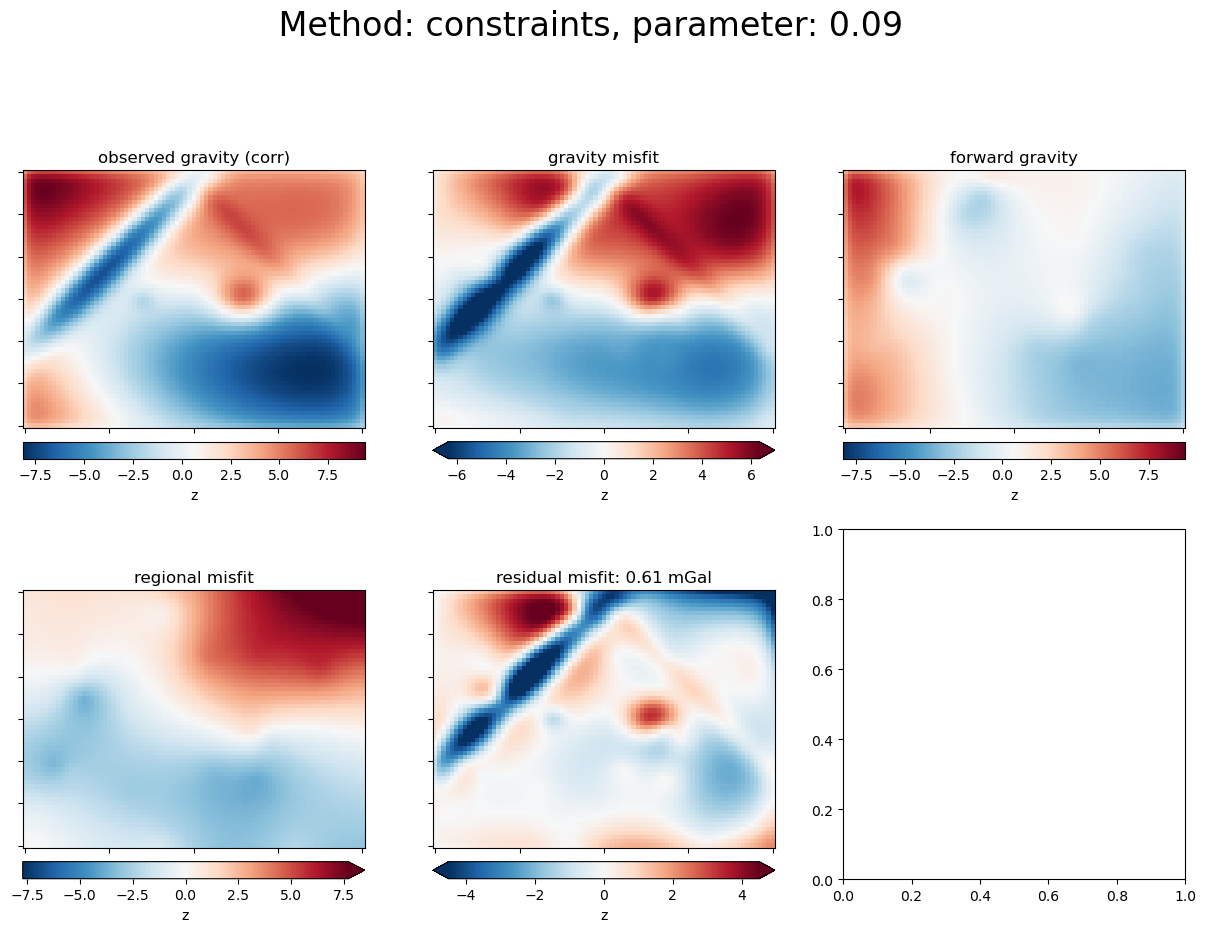

In [15]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
# contraints: 1 results in pedastals, 0 is good,
# param = .25

# or use the best parameter from the optimization
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]

df_anomalies = regional.regional_seperation(
    input_grav=grav,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
    grav_spacing=grav_spacing,
    regional_method=regional_method,
    inversion_region=inversion_region,
    filter=f"g{param}",
    trend=param,
    fill_method="pygmt",
    constraints=constraint_points,
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
)

anom_grids = plotting.anomalies_plotting(
    df_anomalies,
    region=inversion_region,
    grav_spacing=grav_spacing,
    title=f" Method: {regional_method}, parameter: {param}",
    # constraints=constraint_points,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
)

# Plot Inputs

In [22]:
# grid the residual misfit
residual = pygmt.surface(
    data=df_anomalies[["x", "y", "res"]],
    region=inversion_region,
    spacing=grav_spacing,
    T=0.25,
    # M="0c",
    registration=registration,
)

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


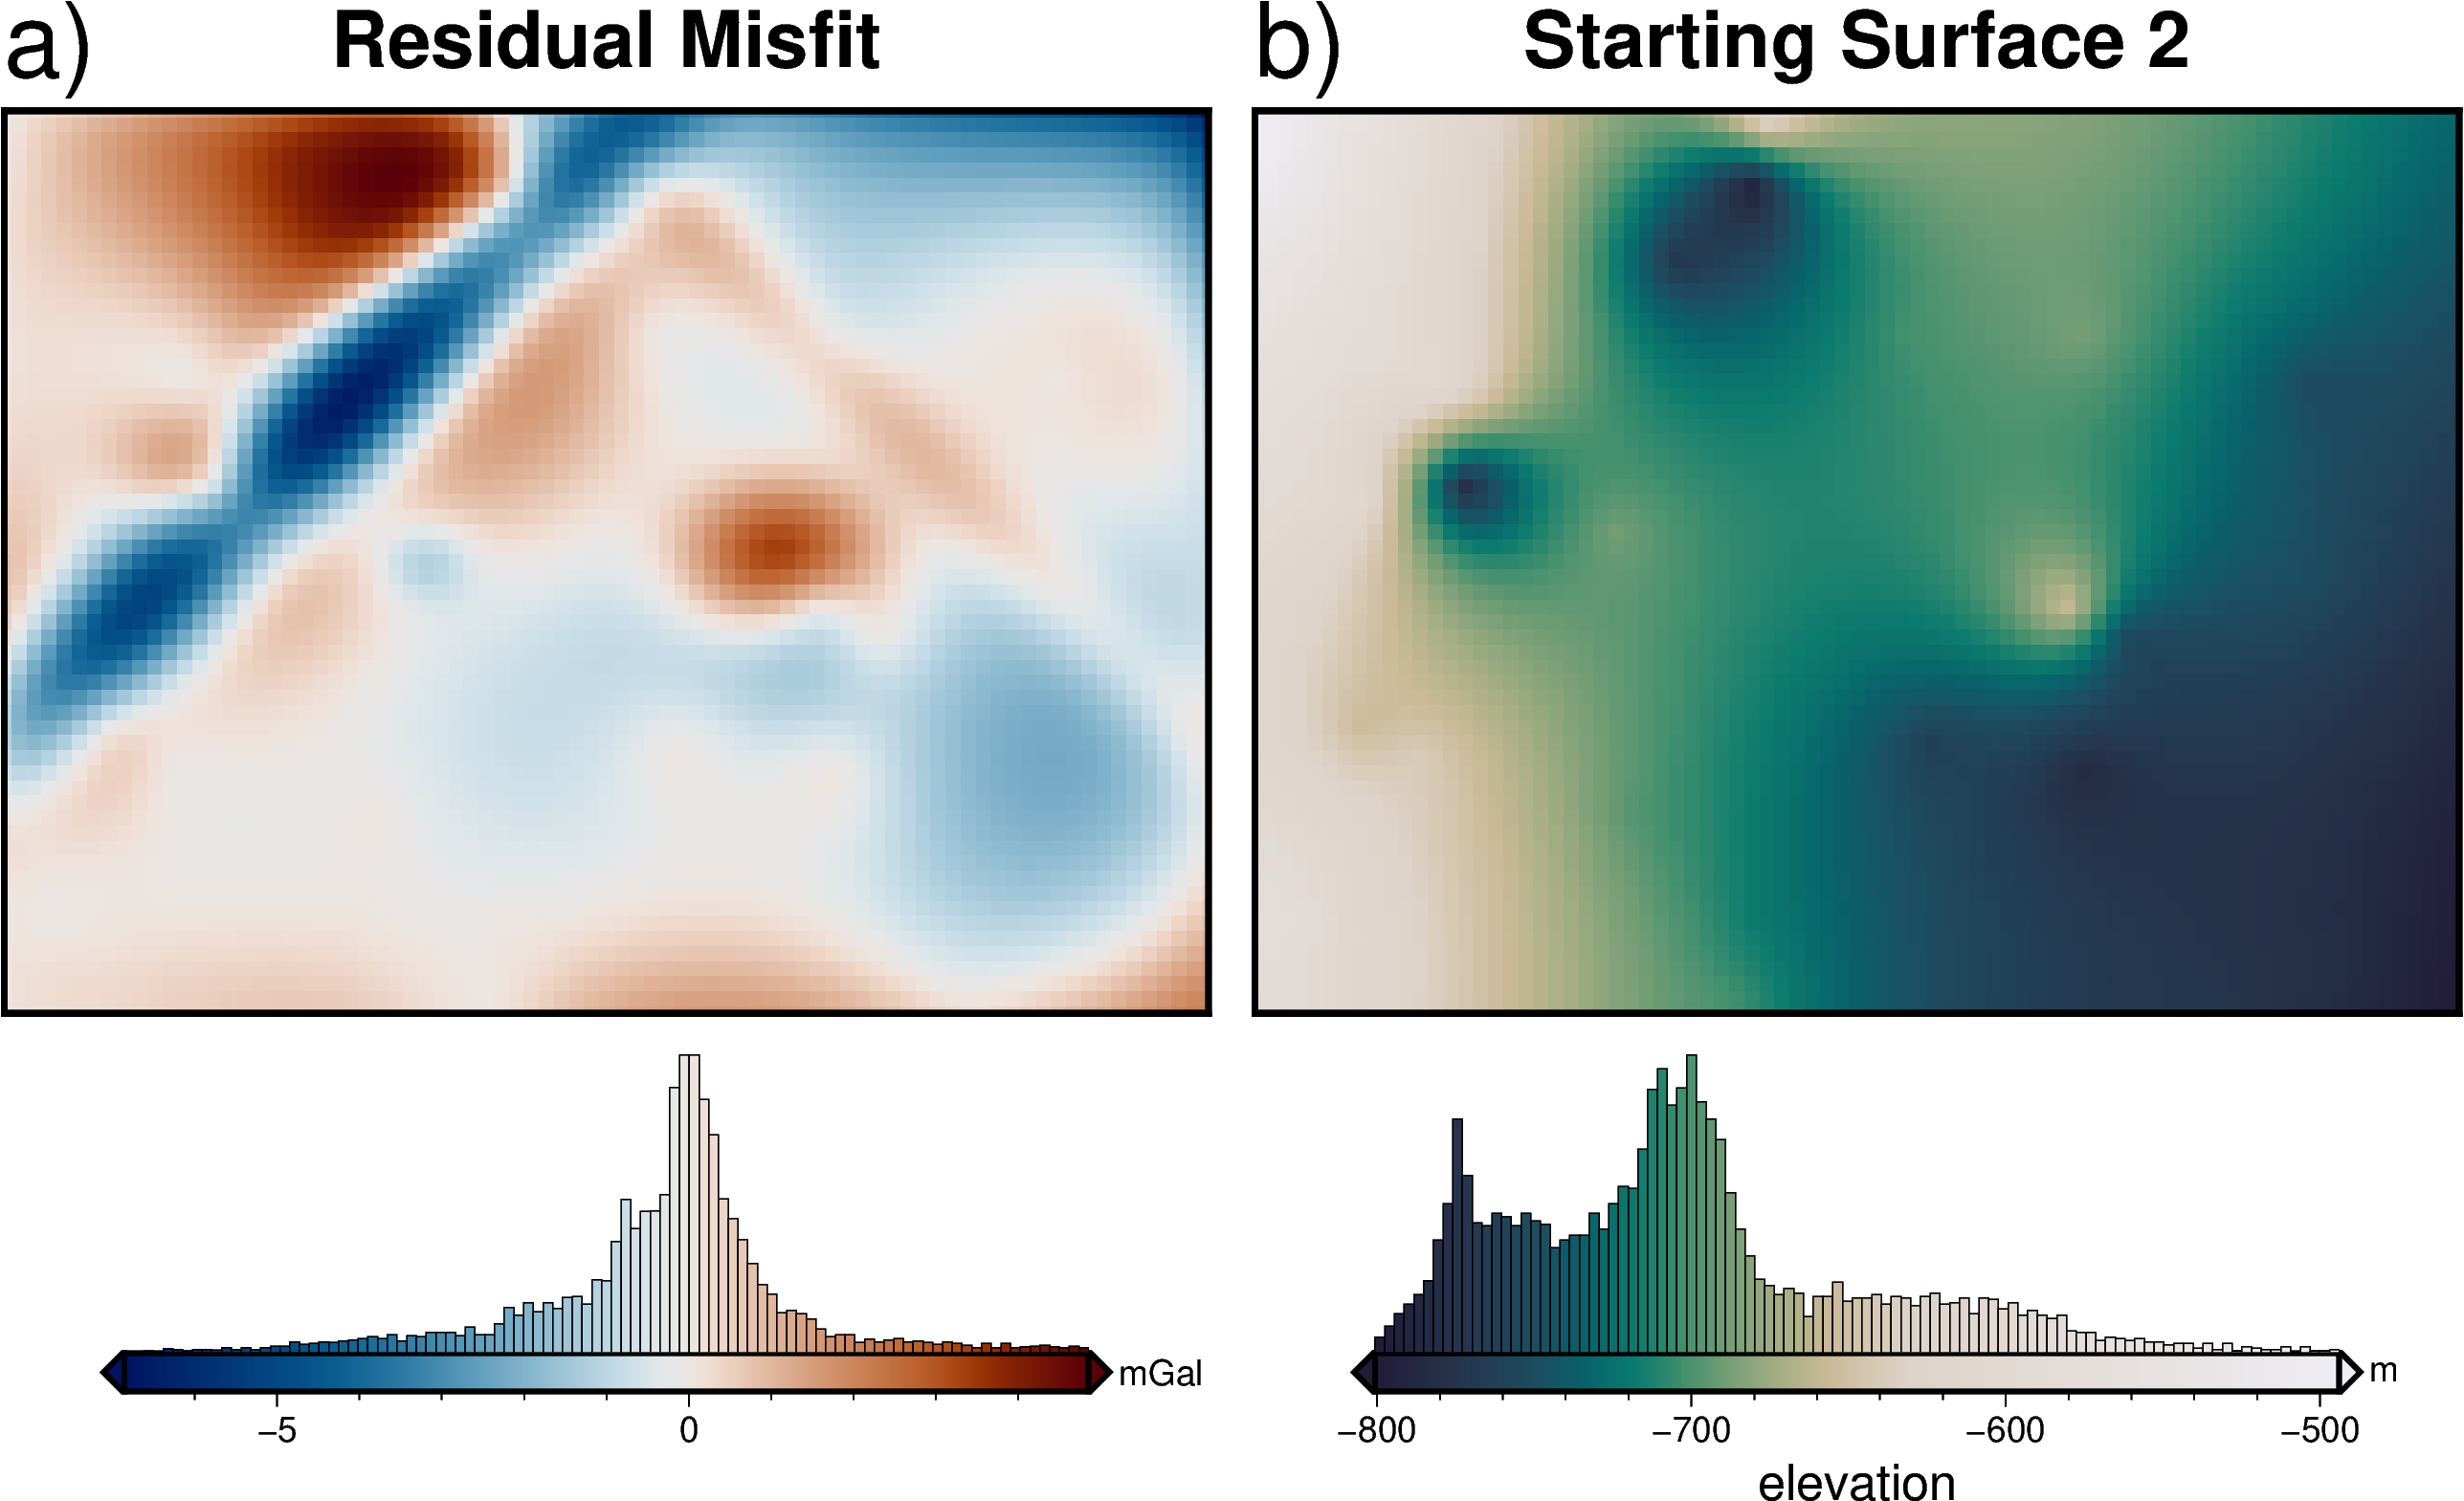

In [ ]:
# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. 

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Jacobian methods (annulus vs small prisms)
* Solver methods (Scipy lsqr vs Verde lsqr)
* Solver damping
* max prism change per iteration

In [39]:
# prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
#     input_grav=df_anomalies,
#     input_grav_column = 'Gobs_corr',
#     prism_layer=layer2_prisms,

#     max_iterations=3,

#     # optional
#     l2_norm_tolerance=.2,
#     delta_l2_norm_tolerance=.8, #1.001,

#     # Jacobian options
#     # deriv_type = "annulus",
#     deriv_type = "prisms",
#     # jacobian_prism_size = 1, # doesn't seem to make a difference

#     # Solver options
#     # Damping: scipy least squares and verde least squares
#     # Weighting: verde least squares
#     solver_type = "verde least squares",
#     solver_damping = 1e4,

#     # solver_type = "scipy least squares",
#     # solver_damping = .01,
# )

In [40]:
# grids = plotting.plot_inversion_results(
#     grav_results,
#     prism_results,
#     params,
#     grav_region=inversion_region,
#     grav_spacing=grav_spacing,
#     constraints=constraint_points,
#     plot_topo_results=False,
#     plot_grav_results=False,
#     iters_to_plot=4,
#     )

## Optimization

In [16]:
# set kwargs for inversion
no_noise_kwargs = dict(
    input_grav=df_anomalies,
    input_grav_column="Gobs_corr",
    prism_layer=layer2_prisms,
    max_iterations=50,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=0.8,
)

In [19]:
# set name and storage for the optimization
study_name = "2layer_inversion_with_regional_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials = 100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = optimization.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **no_noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

/tmp/ipykernel_3506924/3295426279.py:3: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



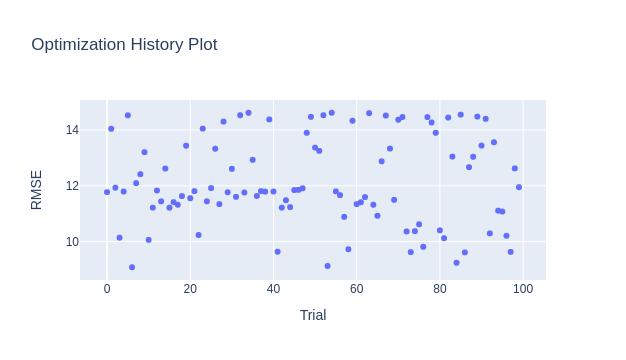

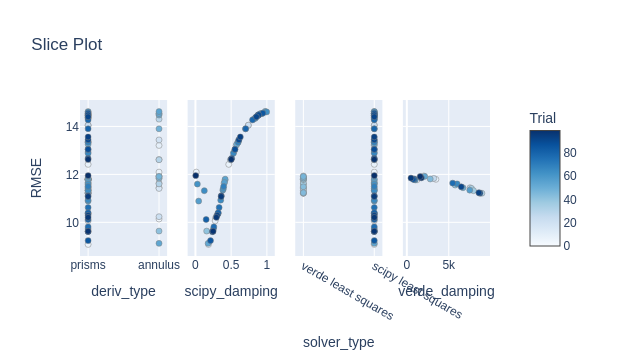

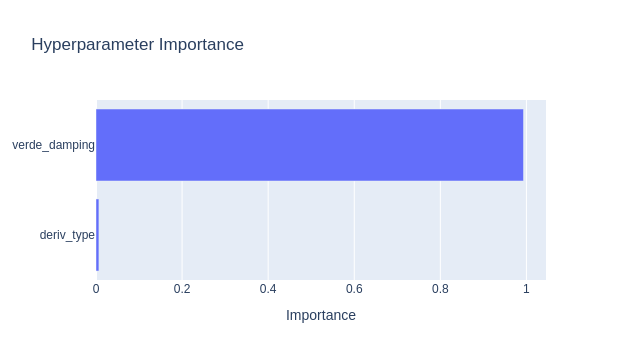

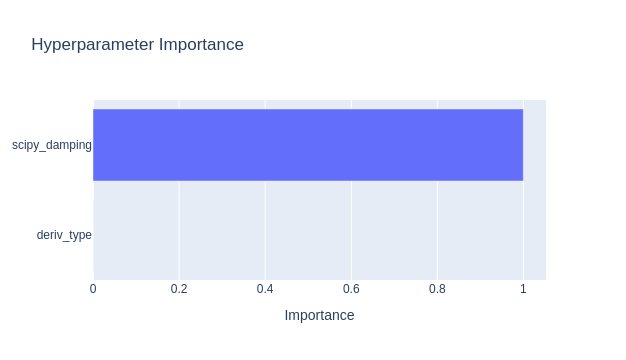

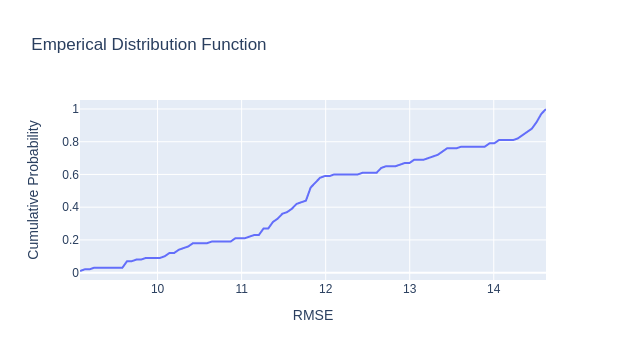

In [20]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [21]:
start = study.trials_dataframe().sort_values(by="datetime_start").iloc[0].datetime_start
stop = (
    study.trials_dataframe()
    .sort_values(by="datetime_complete", ascending=False)
    .iloc[0]
    .datetime_complete
)

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

Total time for optimizaiton: 24.137156683333334 minutes


In [22]:
(
    df,
    best_verde,
    best_scipy,
    best_prisms,
    best_annulus,
) = optimization.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

best trial w/ solver = verde: index 15
best trial w/ solver = scipy: index 6
best trial w/ deriv = prisms: index 6
best trial w/ deriv = annulus: index 53


number      value             datetime_start          datetime_complete  \
6        6   9.077217 2023-02-28 23:00:54.014999 2023-02-28 23:23:58.311233   
53      53   9.123412 2023-02-28 23:01:01.042482 2023-02-28 23:14:54.742099   
84      84   9.238031 2023-02-28 23:00:52.892292 2023-02-28 23:24:06.117374   
86      86   9.610264 2023-02-28 23:01:00.342502 2023-02-28 23:25:00.721137   
73      73   9.620322 2023-02-28 23:01:02.009415 2023-02-28 23:22:58.833590   
..     ...        ...                        ...                        ...   
32      32  14.532975 2023-02-28 23:00:57.446917 2023-02-28 23:23:22.096580   
85      85  14.553358 2023-02-28 23:01:02.597606 2023-02-28 23:24:41.881718   
63      63  14.605696 2023-02-28 23:00:59.862923 2023-02-28 23:23:11.754712   
34      34  14.620445 2023-02-28 23:00:55.966518 2023-02-28 23:22:59.068632   
54      54  14.621520 2023-02-28 23:00:58.898747 2023-02-28 23:14:00.054236   

                 duration params_deriv_type  params_scipy_damping  \
6  0 days 00:23:04.296234            prisms              0.182937   
53 0 days 00:13:53.699617           annulus              0.178048   
84 0 days 00:23:13.225082            prisms              0.211051   
86 0 days 00:24:00.378635            prisms              0.236983   
73 0 days 00:21:56.824175            prisms              0.242295   
..                    ...               ...                   ...   
32 0 days 00:22:24.649663            prisms              0.914828   
85 0 days 00:23:39.284112            prisms              0.943593   
63 0 days 00:22:11.891789            prisms              0.996643   
34 0 days 00:22:03.102114            prisms              0.976533   
54 0 days 00:13:01.155489           annulus              0.977588   

     params_solver_type  params_verde_damping     state  
6   scipy least squares                   NaN  COMPLETE  
53  scipy least squares                   NaN  COMPLETE  
84  scipy least squares                   NaN  COMPLETE  
86  scipy least squares                   NaN  COMPLETE  
73  scipy least squares                   NaN  COMPLETE  
..                  ...                   ...       ...  
32  scipy least squares                   NaN  COMPLETE  
85  scipy least squares                   NaN  COMPLETE  
63  scipy least squares                   NaN  COMPLETE  
34  scipy least squares                   NaN  COMPLETE  
54  scipy least squares                   NaN  COMPLETE  

[100 rows x 10 columns]

{'deriv_type': 'prisms', 'solver_type': 'scipy least squares', 'scipy_damping': 0.18293711796576295}
returning original grid
returning original grid
RMSE between surfaces at constraints: 2.94 m


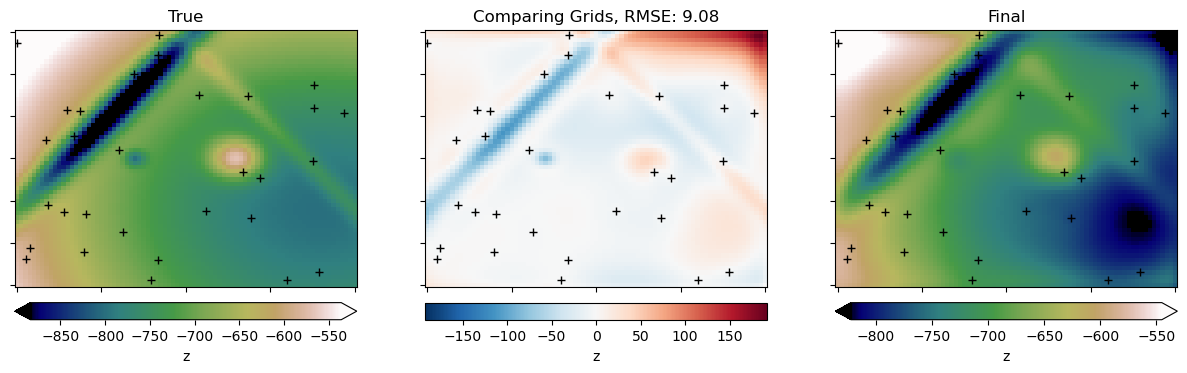

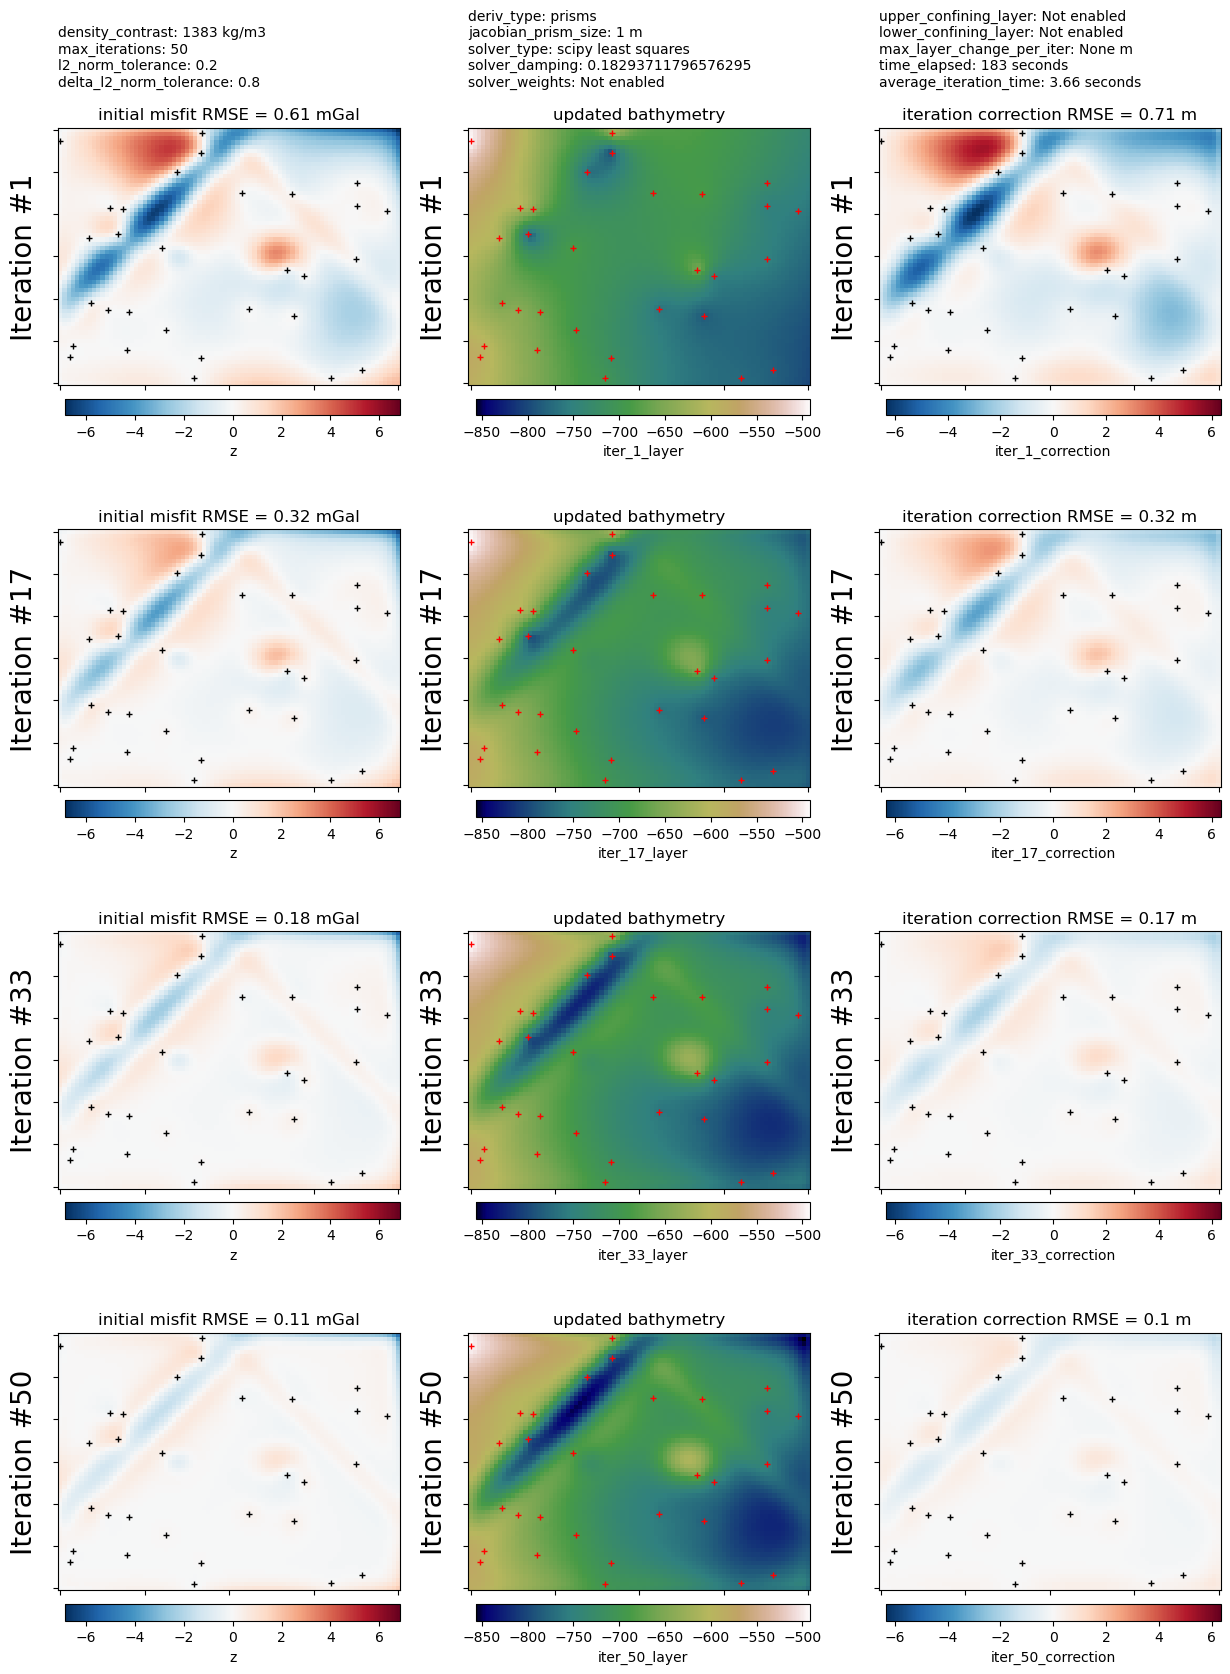

In [23]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **no_noise_kwargs
)

{'deriv_type': 'annulus', 'solver_type': 'scipy least squares', 'scipy_damping': 0.17804821323191322}
returning original grid
returning original grid
RMSE between surfaces at constraints: 3.1 m


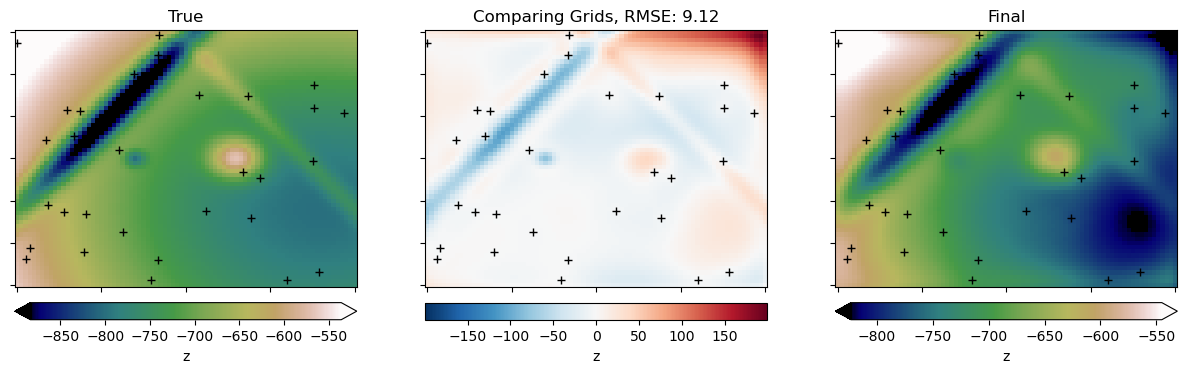

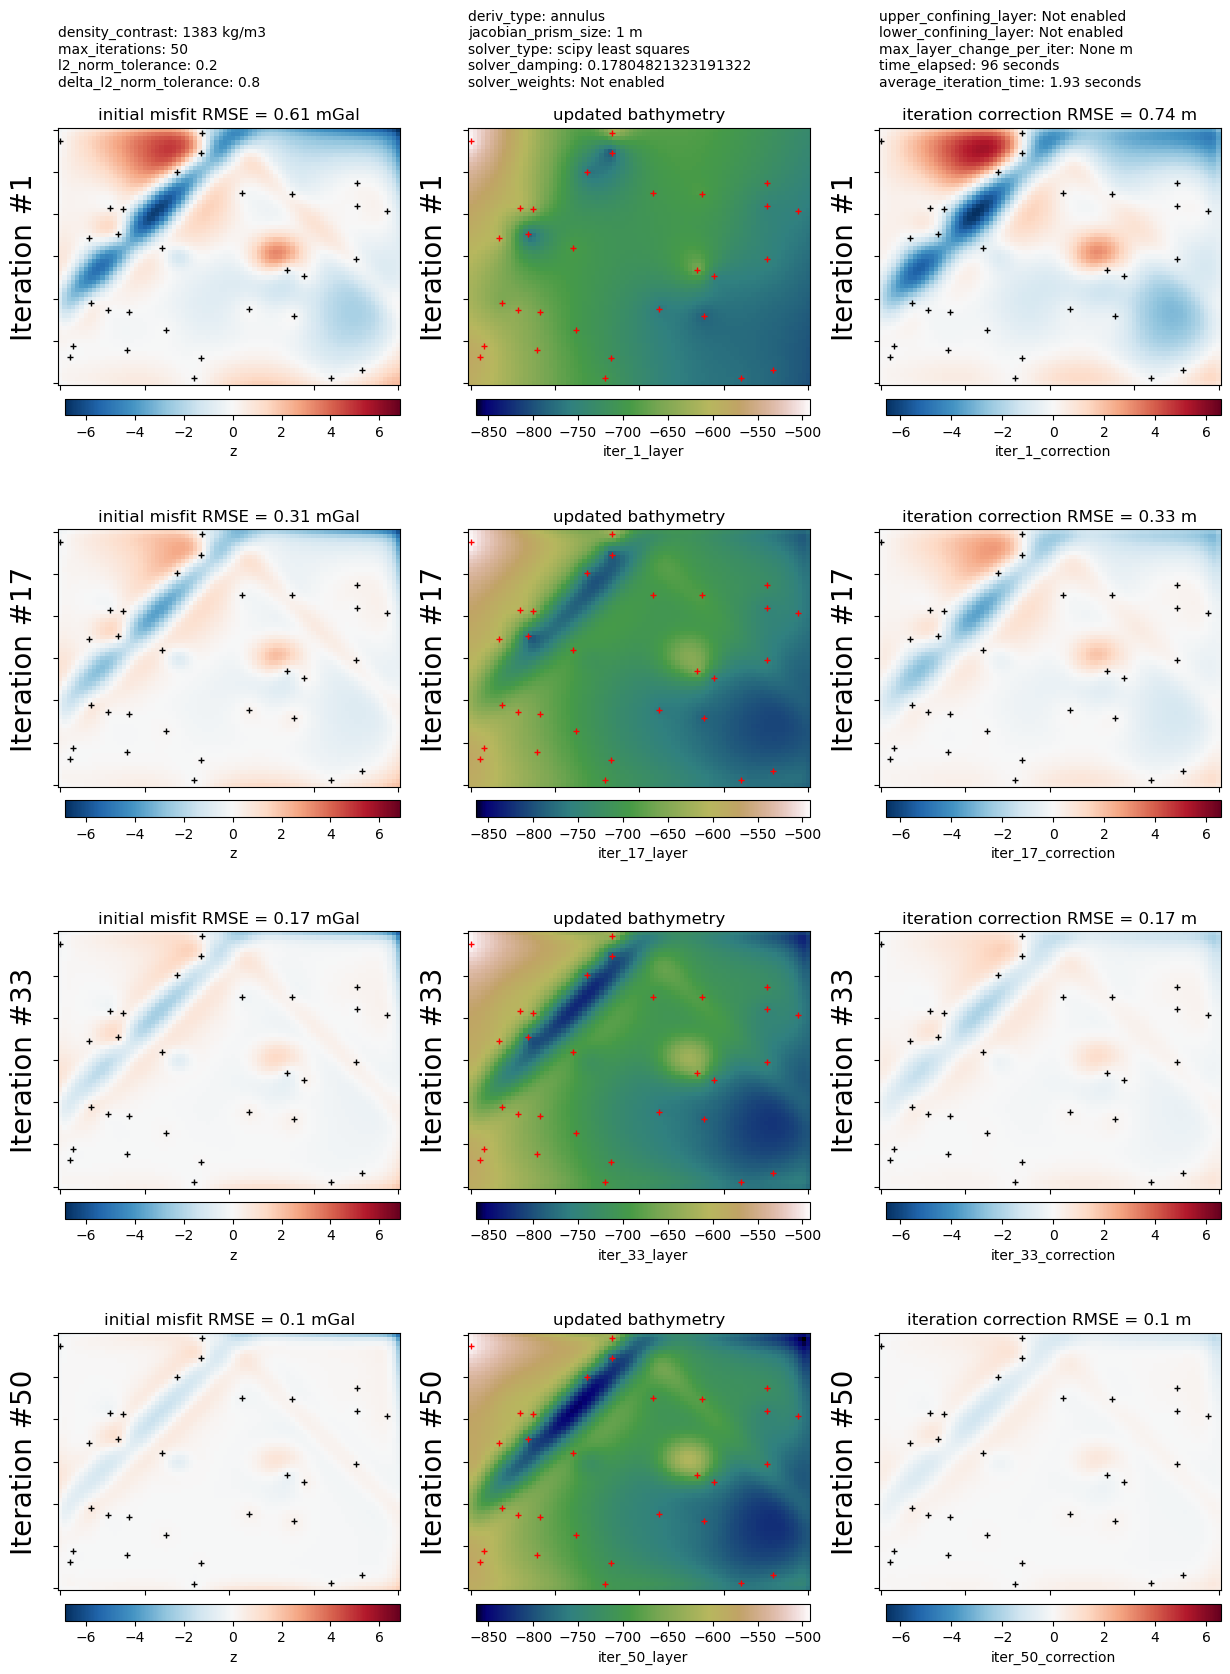

In [24]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **no_noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_verde)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **no_noise_kwargs
)

{'deriv_type': 'prisms', 'solver_type': 'verde least squares', 'verde_damping': 8947.71064784408}
returning original grid


# Repeat with simple noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [20]:
df_anomalies_noise = df_anomalies.copy()

df_anomalies_noise["res"] = synth.contaminate(
    df_anomalies_noise.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_anomalies_noise

y        x    Layer1    Layer2    Layer3       Gobs       z  \
0         0.0      0.0  7.079618  3.117193  0.348744   8.507185  1000.0   
1         0.0   1000.0  8.411450  3.754956  0.323825  10.451861  1000.0   
2         0.0   2000.0  8.769055  4.018826  0.295379  11.044890  1000.0   
3         0.0   3000.0  8.776992  4.091908  0.263643  11.094172  1000.0   
4         0.0   4000.0  8.645779  4.074078  0.229239  10.910725  1000.0   
...       ...      ...       ...       ...       ...        ...     ...   
4936  60000.0  76000.0  1.019056  1.619829  2.836632   3.437148  1000.0   
4937  60000.0  77000.0  1.105780  1.598040  2.715206   3.380656  1000.0   
4938  60000.0  78000.0  1.194986  1.552608  2.566119   3.275342  1000.0   
4939  60000.0  79000.0  1.282108  1.453309  2.389775   3.086822  1000.0   
4940  60000.0  80000.0  1.354322  1.245943  2.192249   2.754144  1000.0   

      layer1_forward  Gobs_corr  layer2_forward    misfit       reg       res  
0           7.079618   2.493278        2.445618  0.047660  0.122499  0.169523  
1           8.411450   3.106122        2.974444  0.131678  0.080144  0.108846  
2           8.769055   3.341546        3.201610  0.139936  0.030503  0.246093  
3           8.776992   3.382891        3.268290  0.114601 -0.025852  0.450210  
4           8.645779   3.330658        3.253918  0.076739 -0.088349  0.423644  
...              ...        ...             ...       ...       ...       ...  
4936        1.019056   3.483802       -0.349516  3.833318  9.222766 -5.434973  
4937        1.105780   3.340586       -0.382226  3.722813  9.317095 -5.683839  
4938        1.194986   3.146067       -0.393327  3.539395  9.407362 -5.996723  
4939        1.282108   2.870425       -0.362025  3.232450  9.493682 -6.176796  
4940        1.354322   2.465532       -0.253643  2.719176  9.576346 -6.917381  

[4941 rows x 13 columns]

In [ ]:
# set kwargs for inversion
noise_kwargs = dict(
    input_grav=df_anomalies_noise,
    input_grav_column="Gobs_corr",
    prism_layer=layer2_prisms,
    max_iterations=50,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=0.8,  # 1.02,
)

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_with_regional_noise_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials = 100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = optimization.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
start = study.trials_dataframe().sort_values(by="datetime_start").iloc[0].datetime_start
stop = (
    study.trials_dataframe()
    .sort_values(by="datetime_complete", ascending=False)
    .iloc[0]
    .datetime_complete
)

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

In [ ]:
(
    df,
    best_verde,
    best_scipy,
    best_prisms,
    best_annulus,
) = optimization.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **noise_kwargs
)

# Repeat with synthetic survey

In [25]:
grav_survey = pd.read_csv(
    "../synthetic_data/synthetic_gravity_simple.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
grav_spacing_survey = 2e3
grav_survey

x        y  lat  lon  station_ID  ellipsoidal_elevation  \
0         0.0      0.0  NaN  NaN         NaN                 1000.0   
1      2000.0      0.0  NaN  NaN         NaN                 1000.0   
2      4000.0      0.0  NaN  NaN         NaN                 1000.0   
3      6000.0      0.0  NaN  NaN         NaN                 1000.0   
4      8000.0      0.0  NaN  NaN         NaN                 1000.0   
...       ...      ...  ...  ...         ...                    ...   
1266  72000.0  60000.0  NaN  NaN         NaN                 1000.0   
1267  74000.0  60000.0  NaN  NaN         NaN                 1000.0   
1268  76000.0  60000.0  NaN  NaN         NaN                 1000.0   
1269  78000.0  60000.0  NaN  NaN         NaN                 1000.0   
1270  80000.0  60000.0  NaN  NaN         NaN                 1000.0   

      geoidal_elevation  elevation_error  observed_gravity  \
0                   NaN              NaN               NaN   
1                   NaN              NaN               NaN   
2                   NaN              NaN               NaN   
3                   NaN              NaN               NaN   
4                   NaN              NaN               NaN   
...                 ...              ...               ...   
1266                NaN              NaN               NaN   
1267                NaN              NaN               NaN   
1268                NaN              NaN               NaN   
1269                NaN              NaN               NaN   
1270                NaN              NaN               NaN   

      observed_gravity_error  gravity_disturbance  gravity_disturbance_error  \
0                        NaN                  NaN                        NaN   
1                        NaN                  NaN                        NaN   
2                        NaN                  NaN                        NaN   
3                        NaN                  NaN                        NaN   
4                        NaN                  NaN                        NaN   
...                      ...                  ...                        ...   
1266                     NaN                  NaN                        NaN   
1267                     NaN                  NaN                        NaN   
1268                     NaN                  NaN                        NaN   
1269                     NaN                  NaN                        NaN   
1270                     NaN                  NaN                        NaN   

      free_air_anomaly  free_air_anomaly_error  
0             9.212099                     NaN  
1            11.439117                     NaN  
2            11.656589                     NaN  
3            10.638682                     NaN  
4             9.417330                     NaN  
...                ...                     ...  
1266          3.621710                     NaN  
1267          3.027327                     NaN  
1268          3.305821                     NaN  
1269          2.903919                     NaN  
1270          2.580453                     NaN  

[1271 rows x 14 columns]

In [26]:
# set standard column names
grav_survey = grav_survey.rename(
    columns={
        "free_air_anomaly": "Gobs",
        "ellipsoidal_elevation": "z",
    }
)

# remove other columns
grav_survey = grav_survey[["x", "y", "Gobs", "z"]]

# center gravity around 0
grav_survey.Gobs -= grav_survey.Gobs.median()

print(f"gravity: {len(grav_survey)} points")
print(f"gravity avg. elevation: {int(np.nanmean(grav_survey.z))}")

# grid the observed gravity
Gobs = grav_survey.set_index(["y", "x"]).to_xarray().Gobs

grav_survey

gravity: 1271 points
gravity avg. elevation: 1000


x        y       Gobs       z
0         0.0      0.0   9.234795  1000.0
1      2000.0      0.0  11.461814  1000.0
2      4000.0      0.0  11.679285  1000.0
3      6000.0      0.0  10.661379  1000.0
4      8000.0      0.0   9.440026  1000.0
...       ...      ...        ...     ...
1266  72000.0  60000.0   3.644406  1000.0
1267  74000.0  60000.0   3.050024  1000.0
1268  76000.0  60000.0   3.328518  1000.0
1269  78000.0  60000.0   2.926615  1000.0
1270  80000.0  60000.0   2.603150  1000.0

[1271 rows x 4 columns]

## Bouguer correction
### Ice prisms

In [27]:
# create prisms around Layer 1
# positive densities above reference, negative below
layer1_prisms = inv_utils.grids_to_prisms(
    surface=layer1,
    reference=layer1.values.mean(),
    density=xr.where(layer1 >= layer1.values.mean(), 917, -917),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

### Ice gravity

In [28]:
# calculate gravity of layer1
layer1_grid, layer1_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    grav_survey,
    names=["layer1_prisms"],
    remove_median=True,
    progressbar=True,
    plot=False,
)

grav_survey["layer1_forward"] = layer1_df.forward_total

# subtract from observed gravity
grav_survey["Gobs_corr"] = grav_survey.Gobs - grav_survey.layer1_forward

# center on 0
grav_survey["Gobs_corr"] -= grav_survey["Gobs_corr"].median()

# grid the results
layer1_forward = grav_survey.set_index(["y", "x"]).to_xarray().layer1_forward
Gobs_corr = grav_survey.set_index(["y", "x"]).to_xarray().Gobs_corr

# center on 0
layer1_forward -= np.median(layer1_forward)
Gobs_corr -= np.median(Gobs_corr.values)
grav_survey

  0%|                                                  | 0/1271 [00:00<?, ?it/s]

x        y       Gobs       z  layer1_forward  Gobs_corr
0         0.0      0.0   9.234795  1000.0        6.931731   3.160000
1      2000.0      0.0  11.461814  1000.0        8.621168   3.697581
2      4000.0      0.0  11.679285  1000.0        8.497891   4.038328
3      6000.0      0.0  10.661379  1000.0        8.073681   3.444632
4      8000.0      0.0   9.440026  1000.0        7.572401   2.724560
...       ...      ...        ...     ...             ...        ...
1266  72000.0  60000.0   3.644406  1000.0        0.570225   3.931116
1267  74000.0  60000.0   3.050024  1000.0        0.710654   3.196305
1268  76000.0  60000.0   3.328518  1000.0        0.871169   3.314284
1269  78000.0  60000.0   2.926615  1000.0        1.047098   2.736451
1270  80000.0  60000.0   2.603150  1000.0        1.206435   2.253650

[1271 rows x 6 columns]

returning original grid
returning original grid


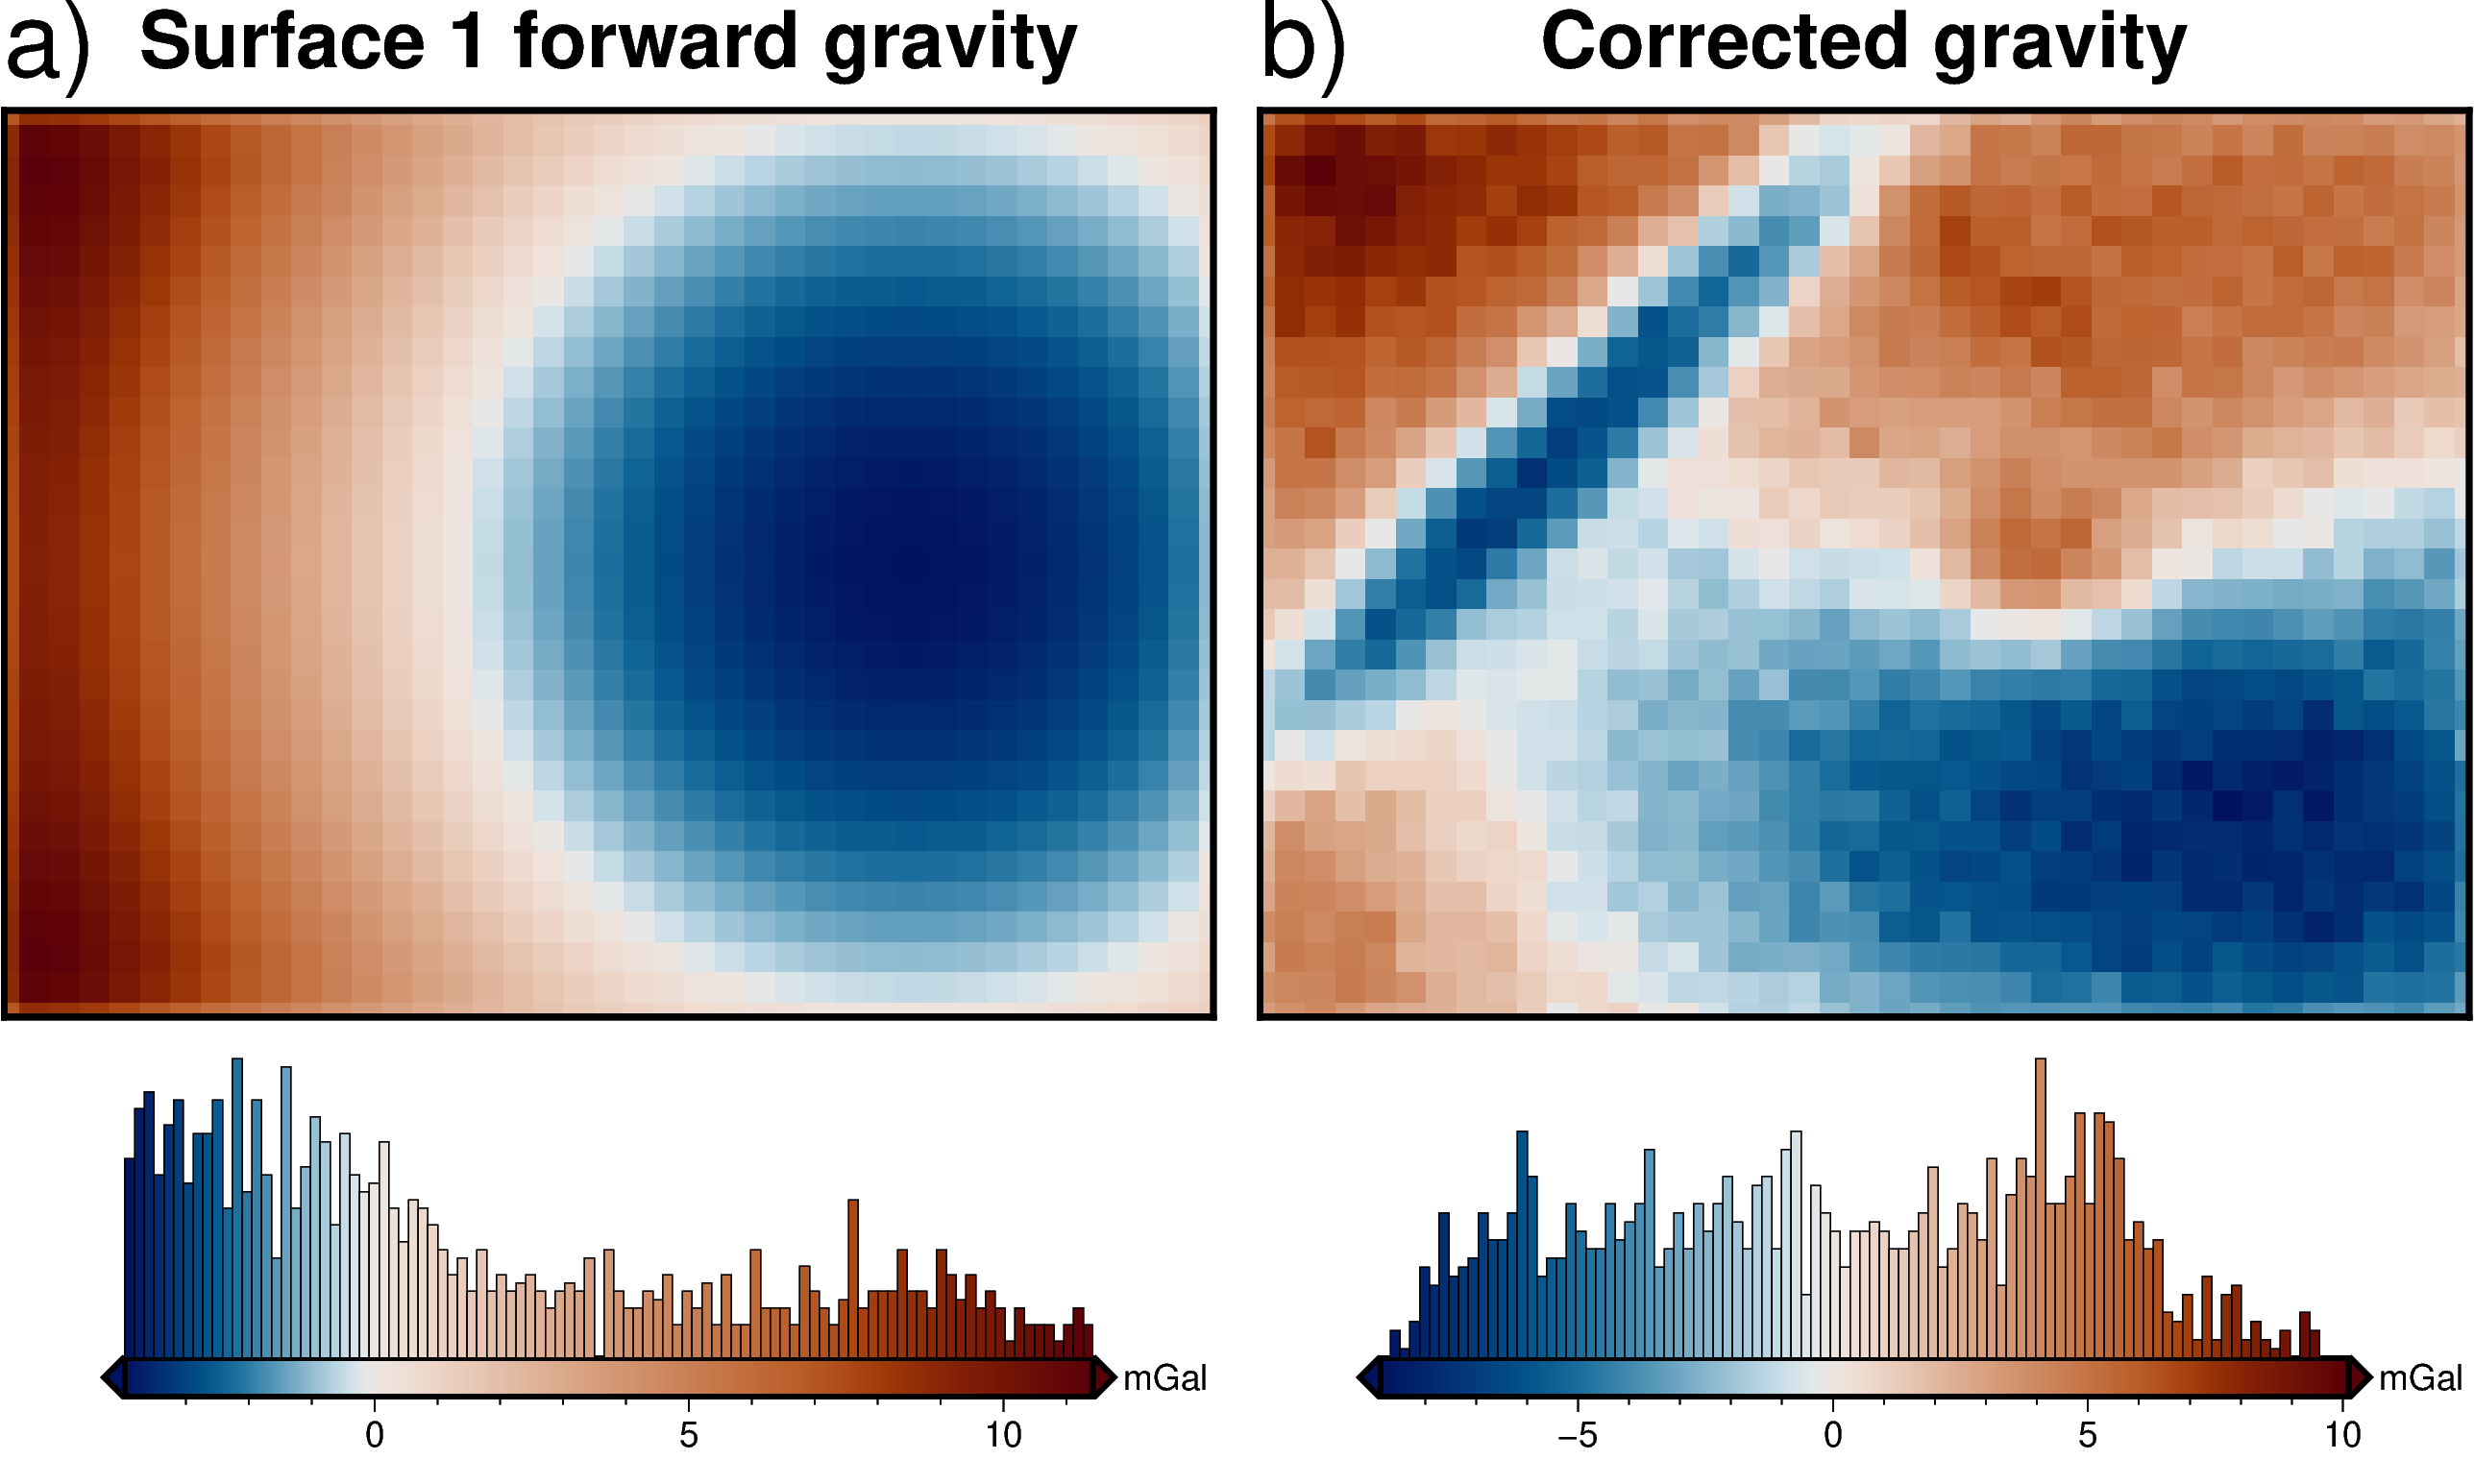

In [45]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=layer1_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Surface 1 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig.show()

## Gravity misfit
### Bed prisms

In [29]:
# create prisms around Layer 2
# positive densities above reference, negative below
layer2_prisms = inv_utils.grids_to_prisms(
    surface=starting_layer2,
    reference=starting_layer2.values.mean(),
    density=xr.where(
        starting_layer2 >= starting_layer2.values.mean(), 2300 - 917, -(2300 - 917)
    ),
)

# plotting.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

### Bed gravity

In [30]:
# calculate gravity of layer1
layer2_forward, layer2_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    grav_survey,
    names=["layer2_prisms"],
    remove_median=True,
    progressbar=True,
    plot=False,
)
layer2_forward = layer2_forward.forward_total

grav_survey["layer2_forward"] = layer2_df.forward_total
grav_survey

  0%|                                                  | 0/1271 [00:00<?, ?it/s]

x        y       Gobs       z  layer1_forward  Gobs_corr  \
0         0.0      0.0   9.234795  1000.0        6.931731   3.160000   
1      2000.0      0.0  11.461814  1000.0        8.621168   3.697581   
2      4000.0      0.0  11.679285  1000.0        8.497891   4.038328   
3      6000.0      0.0  10.661379  1000.0        8.073681   3.444632   
4      8000.0      0.0   9.440026  1000.0        7.572401   2.724560   
...       ...      ...        ...     ...             ...        ...   
1266  72000.0  60000.0   3.644406  1000.0        0.570225   3.931116   
1267  74000.0  60000.0   3.050024  1000.0        0.710654   3.196305   
1268  76000.0  60000.0   3.328518  1000.0        0.871169   3.314284   
1269  78000.0  60000.0   2.926615  1000.0        1.047098   2.736451   
1270  80000.0  60000.0   2.603150  1000.0        1.206435   2.253650   

      layer2_forward  
0           2.426259  
1           3.182251  
2           3.234560  
3           3.089210  
4           2.872601  
...              ...  
1266       -0.156790  
1267       -0.272479  
1268       -0.368875  
1269       -0.412686  
1270       -0.273002  

[1271 rows x 7 columns]

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


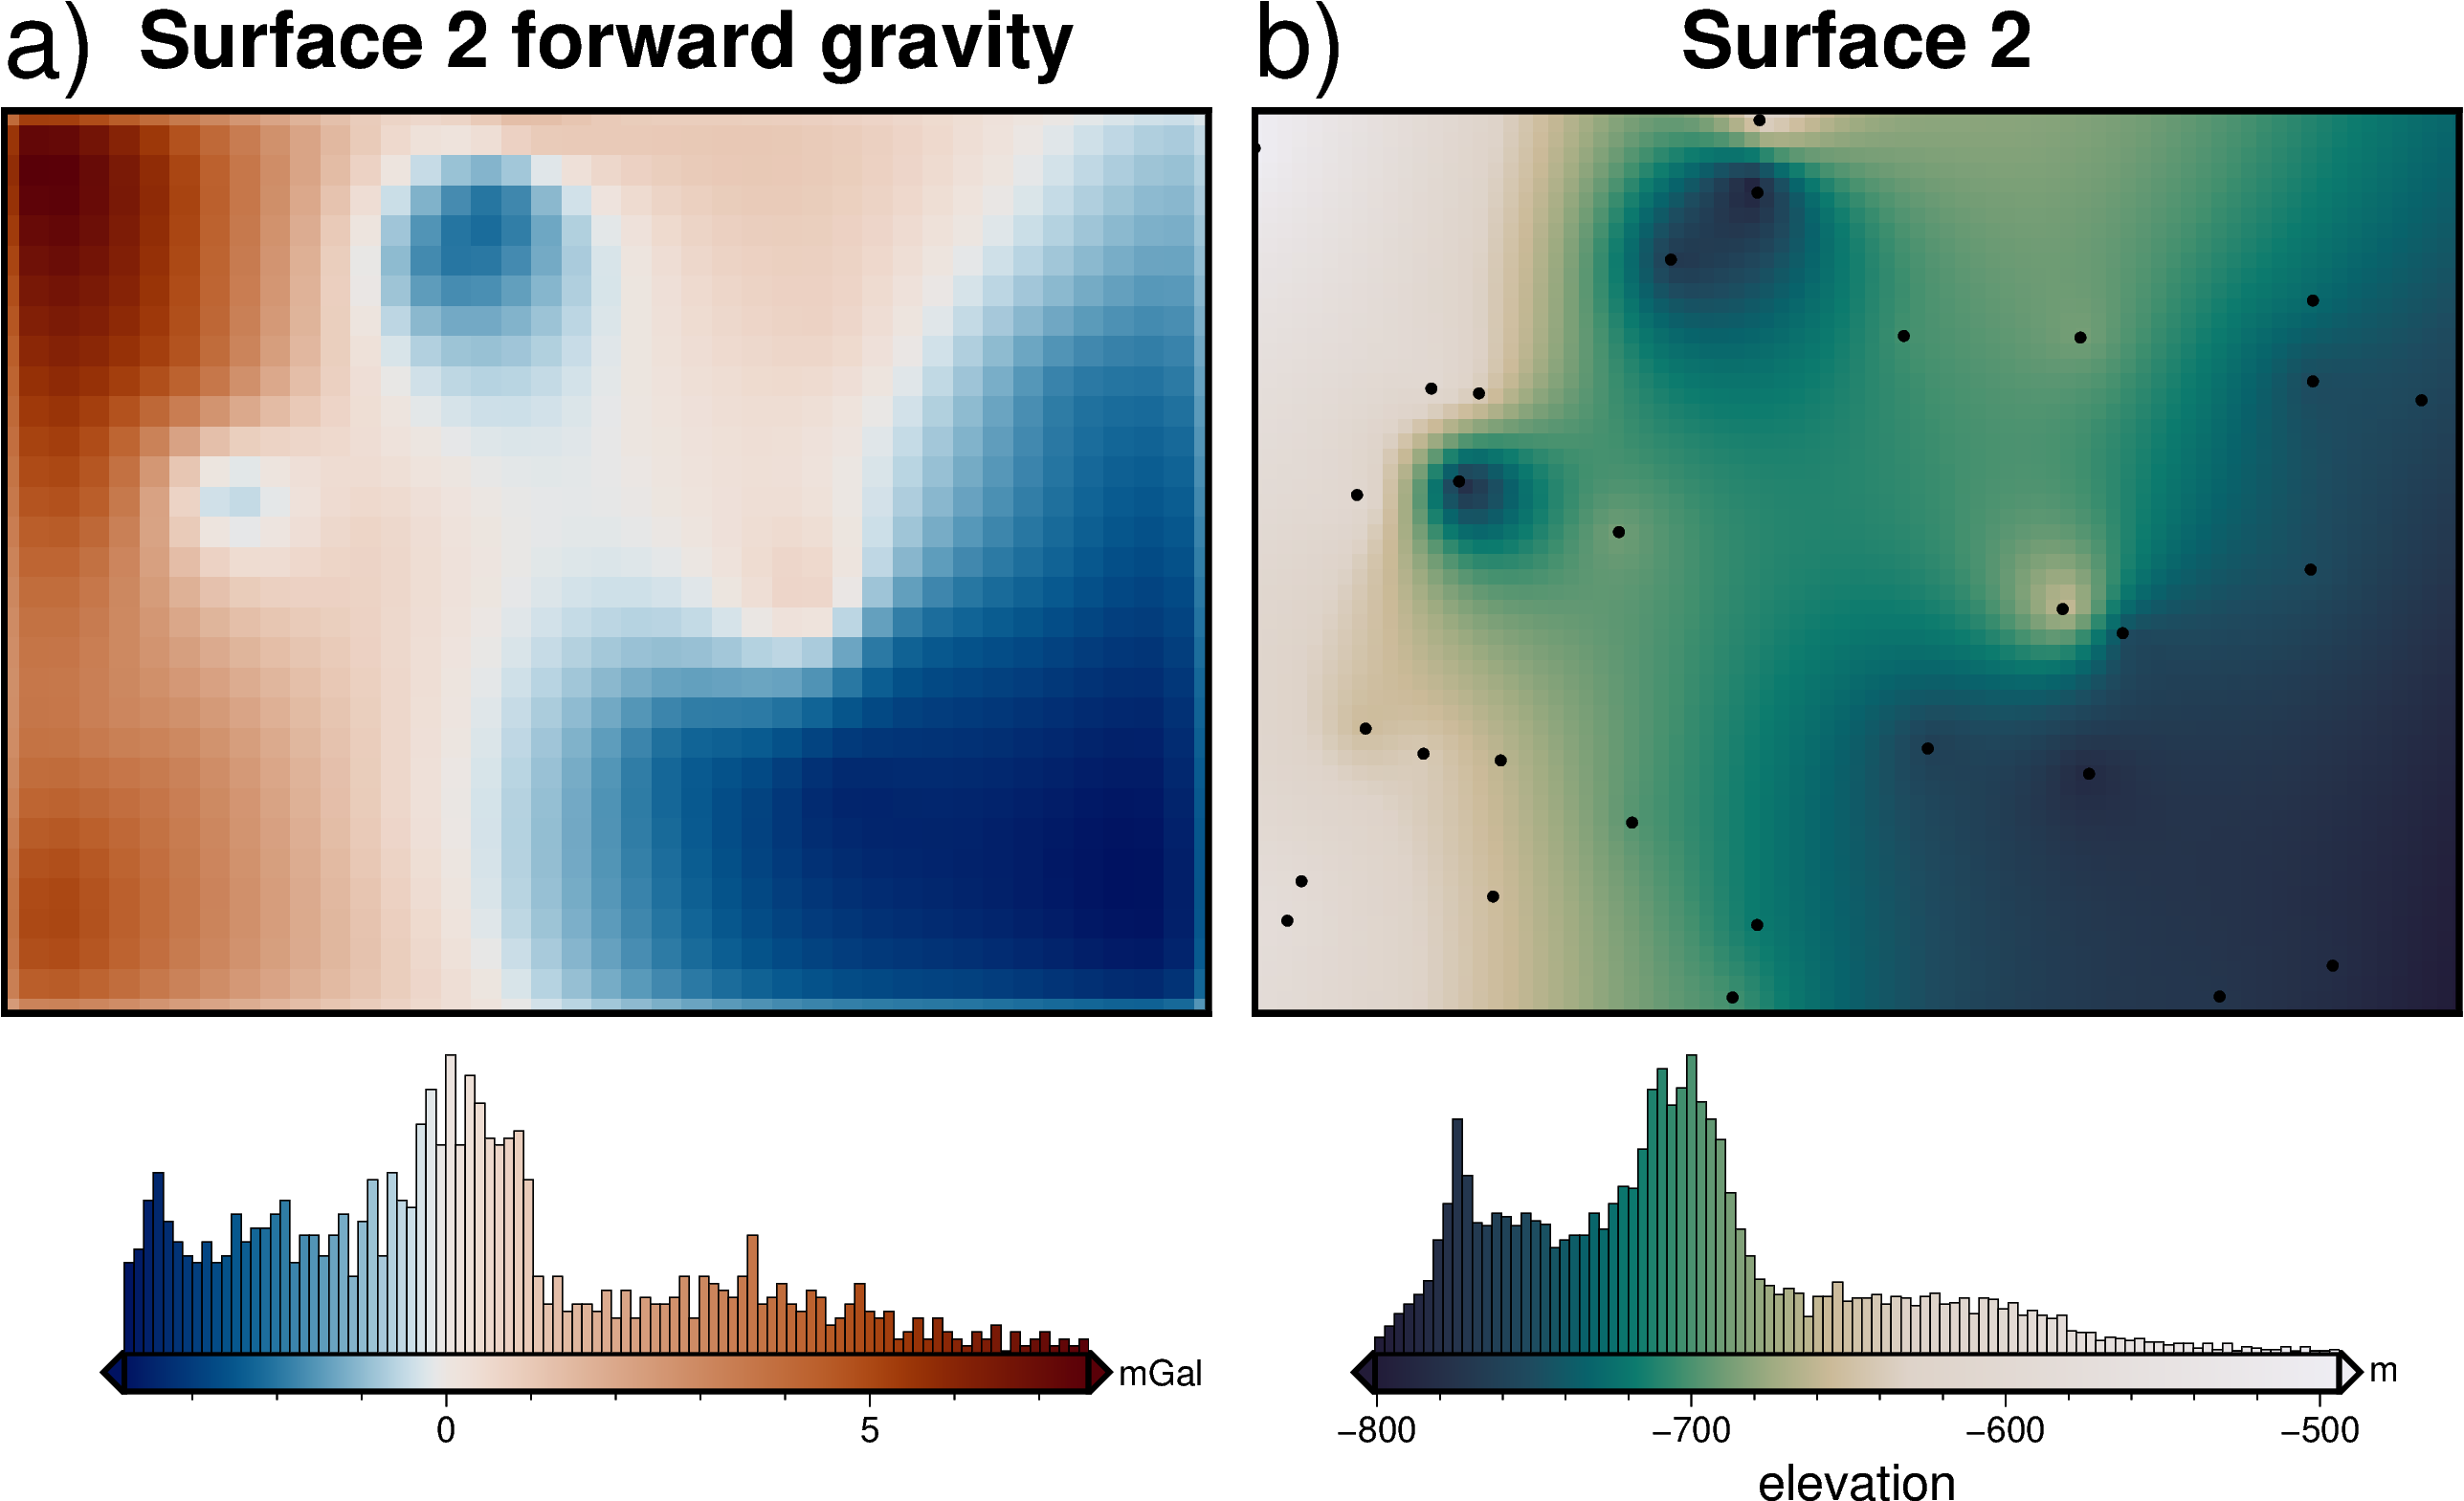

In [48]:
# plot layer 2 gravity
fig = maps.plot_grd(
    grid=layer2_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Surface 2 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
# plot layer 2 topography
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig.show()

## Regional - Residual seperation

In [31]:
# load resolution gravity grid
synthetic_gravity = xr.open_zarr(
    "../synthetic_data/synthetic_forward_grav_simple_with_regional.zarr"
)

# load the true regional gravity anomaly
true_layer3_grav_survey = fetch.resample_grid(
    synthetic_gravity.Layer3,
    region=inversion_region,
    spacing=1e3,  # full resolution spacing
    registration=registration,
)

returning original grid


In [347]:
regional_survey_kwargs = dict(
    input_grav=grav_survey,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_layer3_grav,
    constraints=constraint_points,
)

In [32]:
# set comparison method
# comparison_method='minimize_constraints'
comparison_method = "regional_comparison"

methods = ["filter", "trend", "constraints", "eq_sources"]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"regional_seperation_survey_indiv_{i}_{comparison_method}"
#     storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

#     # set number of runs
#     n_trials=50

#     # create a new study
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#         )

#     # define the objective function
#     objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_survey_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = optimization.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#             )

# load studies
study_dfs = []
for i in methods:
    study_name = f"regional_seperation_survey_indiv_{i}_{comparison_method}"
    storage = JournalStorage(
        JournalFileStorage(f"../optimization_logs/{study_name}.log")
    )
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df)

    # plot results
    plotting.plot_best_param(
        study_df, comparison_method, regional_method=i, **regional_survey_kwargs
    )
    optuna.visualization.plot_slice(study).show()

studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v["params_method"] = k

regional_sep_combined_studies = pd.concat(
    studies.values(), ignore_index=True
).sort_values(by="value")

/tmp/ipykernel_2912154/3566485221.py:55: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



NameError: name 'regional_survey_kwargs' is not defined

In [ ]:
df = regional_sep_combined_studies
df.head()

In [ ]:
best_filter = df[df.params_method == "filter"].iloc[0].number
best_trend = df[df.params_method == "trend"].iloc[0].number
best_constraints = df[df.params_method == "constraints"].iloc[0].number
best_eq_sources = df[df.params_method == "eq_sources"].iloc[0].number

print(f"best trial w/ solver = verde: index {best_filter}")
print(f"best trial w/ solver = scipy: index {best_trend}")
print(f"best trial w/ deriv = prisms: index {best_constraints}")
print(f"best trial w/ deriv = annulus: index {best_eq_sources}")

### Best regional seperation

In [ ]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
# contraints: 1 results in pedastals, 0 is good,
# param = .25

# or use the best parameter from the optimization
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]

df_anomalies_survey = regional.regional_seperation(
    input_grav=grav_survey,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
    grav_spacing=grav_spacing,
    regional_method=regional_method,
    inversion_region=inversion_region,
    filter=f"g{param}",
    trend=param,
    fill_method="pygmt",
    constraints=constraint_points,
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
)

anom_grids = plotting.anomalies_plotting(
    df_anomalies_survey,
    region=inversion_region,
    grav_spacing=grav_spacing,
    title=f" Method: {regional_method}, parameter: {param}",
    # constraints=constraint_points,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
)

## plot inputs

In [60]:
# grid the residual misfit
residual = pygmt.surface(
    data=df_anomalies_survey[["x", "y", "res"]],
    region=inversion_region,
    spacing=grav_spacing,
    T=0.25,
    # M="0c",
    registration=registration,
)

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


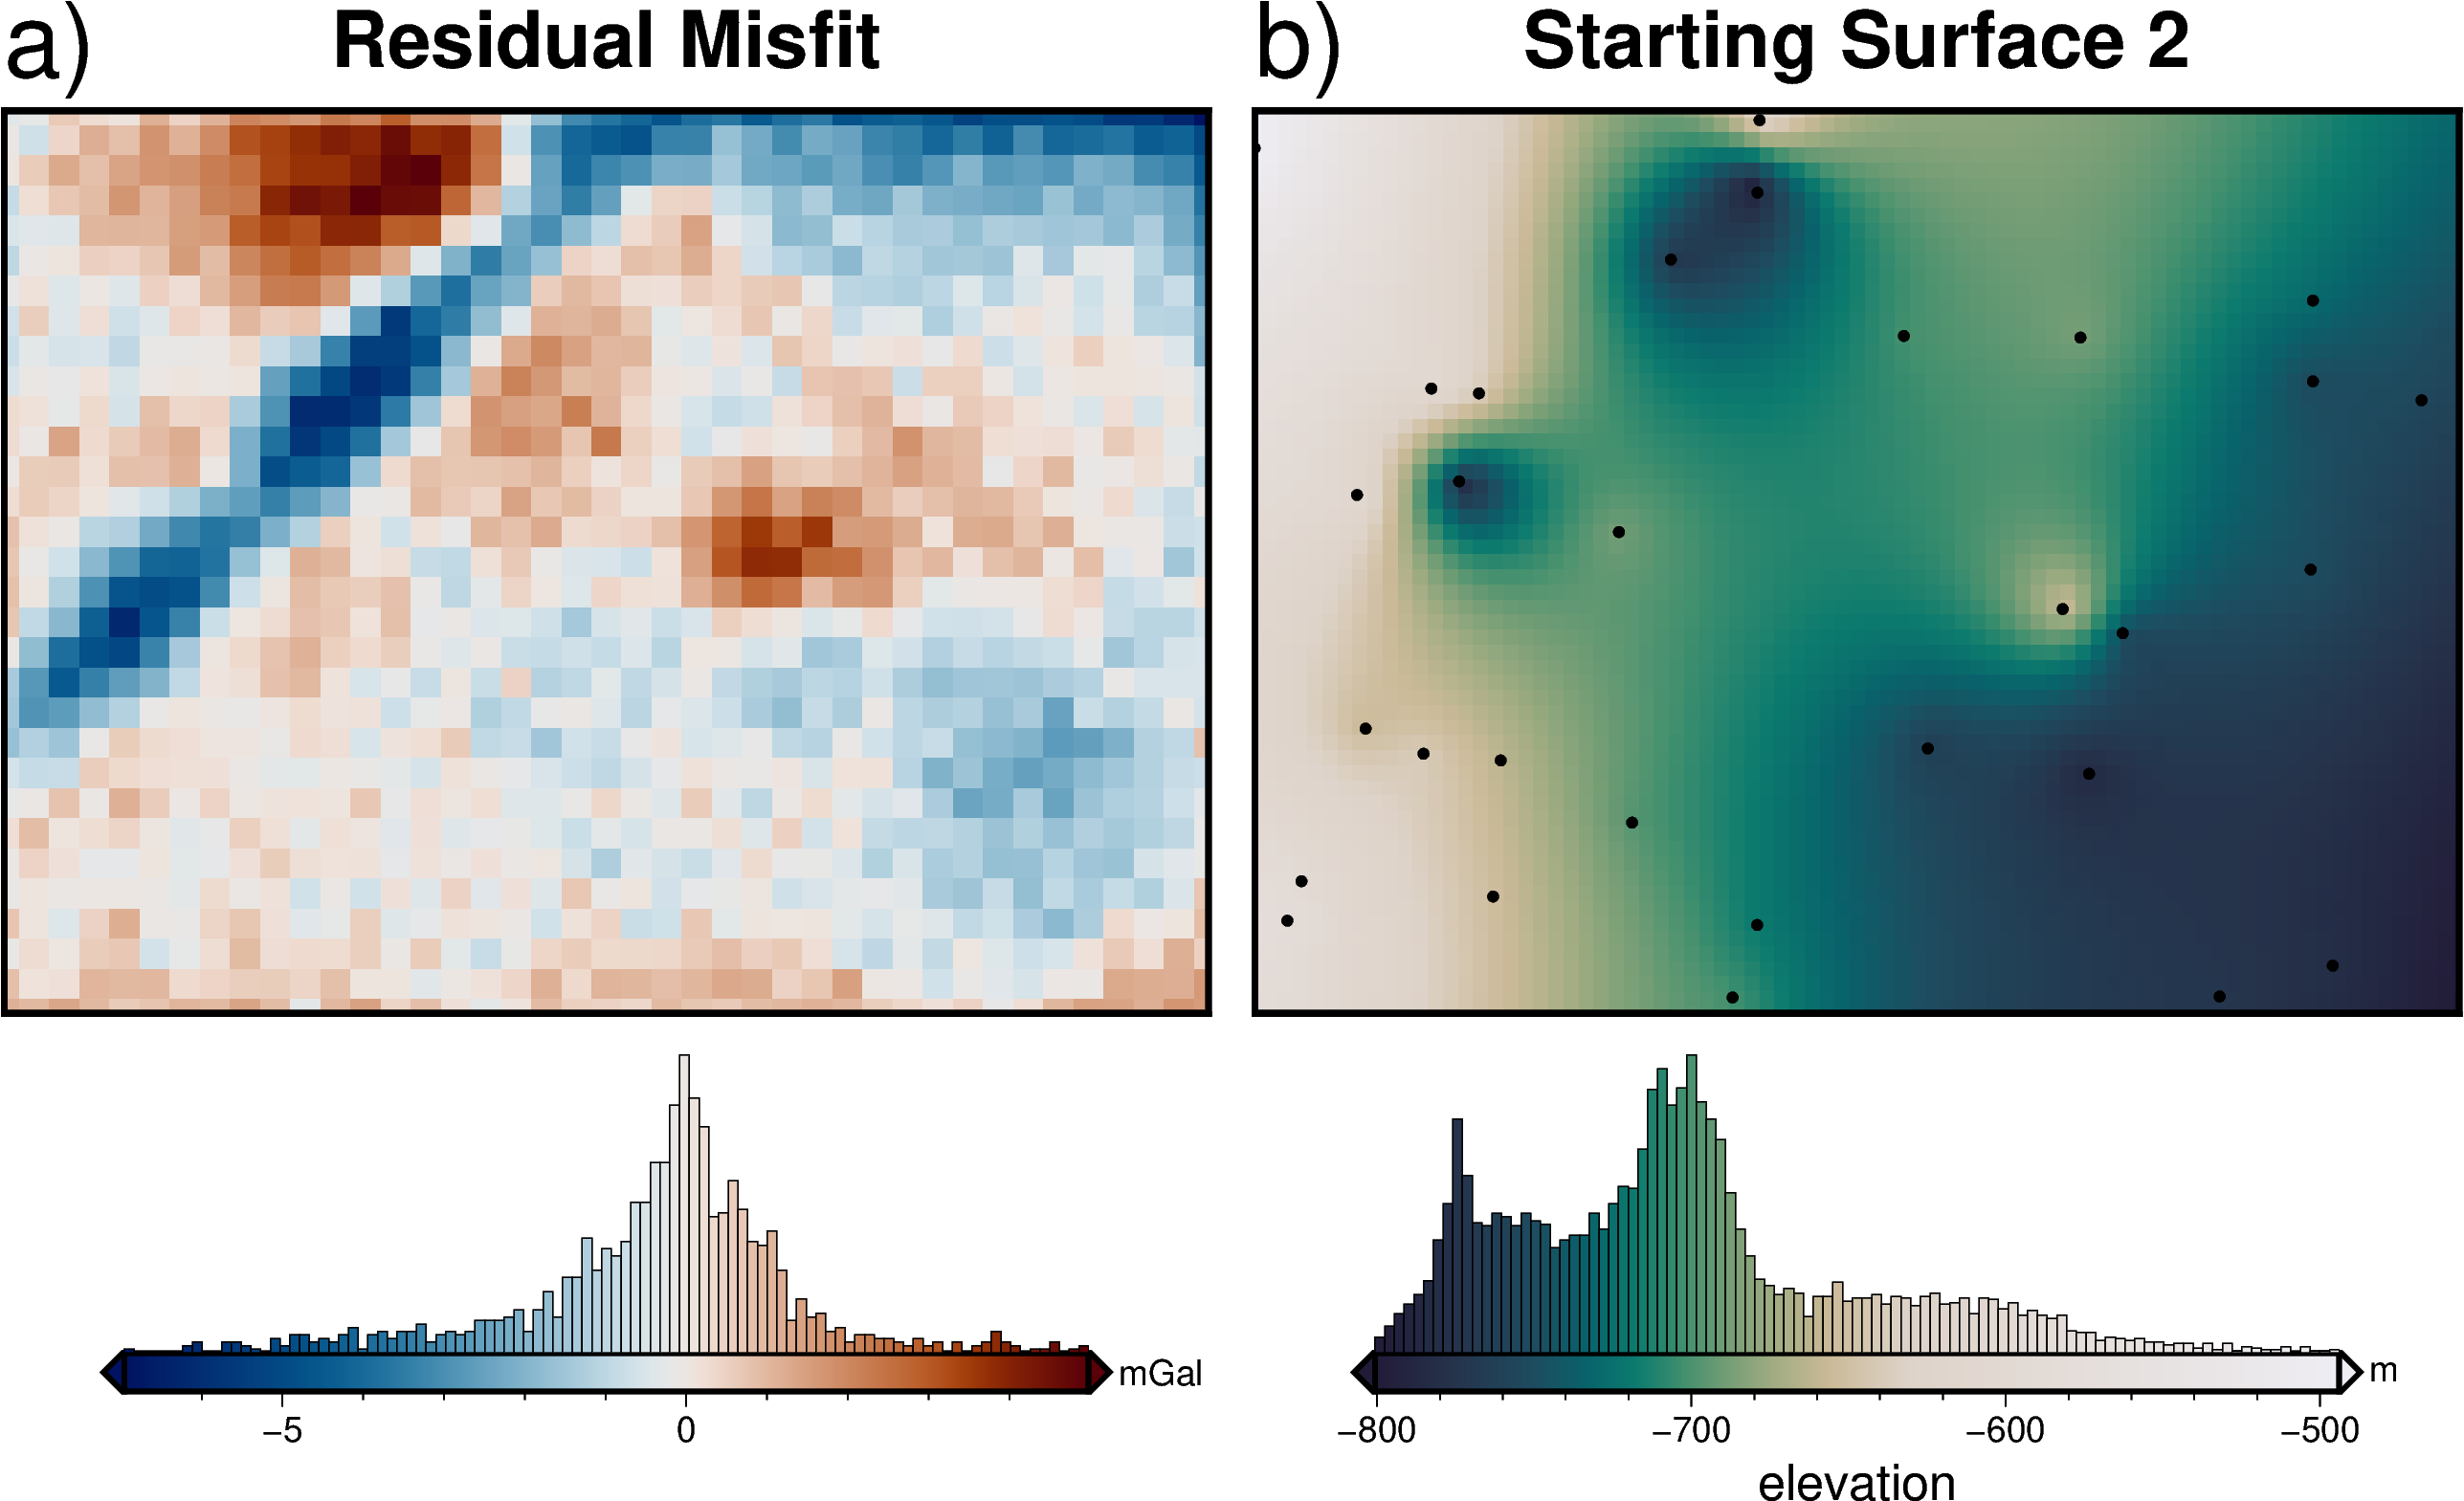

In [61]:
# plot observed gravity
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

## Inversion

In [ ]:
# set kwargs for inversion
survey_kwargs = dict(
    input_grav=df_anomalies_survey,
    input_grav_column="Gobs_corr",
    prism_layer=layer2_prisms,
    max_iterations=50,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=0.8,
)

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_with_regional_survey_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials = 100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# create study
study = optuna.create_study(
    study_name=study_name,
    storage=storage,
    directions=directions,
    # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
    sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials / 3)),
    load_if_exists=True,
)

# define the objective function
objective_func = optimization.optimal_inversion_params(
    true_layer2,
    verde_damping_limits=[0, 1e4],
    scipy_damping_limits=[0, 1],
    objectives=objectives,
    constraints=constraint_points,
    **survey_kwargs,
)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = optimization.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective=objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
    )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
(
    df,
    best_verde,
    best_scipy,
    best_prisms,
    best_annulus,
) = optimization.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **noise_kwargs
)